In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import utils as ut
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
filepath = 'lumber_delivery_preprocessed.csv' # Make sure this path is correct
df = ut.load_and_prep_data(filepath)

Data loaded successfully from lumber_delivery_preprocessed.csv
DataFrame shape: (763, 30)
Date range: 2022-01-03 00:00:00 to 2025-03-17 00:00:00
Columns: ['EXPECTED TYPE A TRUCKS', 'ACTUAL TYPE A TRUCKS', 'OUTSIDE EXTRA TYPE A TRUCKS', 'EXPECTED TYPE B FORK TRUCKS', 'ACTUAL TYPE B TRUCKS', 'EXPECTED TYPE C TRUCKS', 'ACTUAL TYPE C TRUCKS', 'LARGE DELIVERIES (LBS)', 'SMALL DELIVERIES (LBS)', 'LARGE DELIVERIES (QTY)', 'SMALL DELIVERIES (QTY)', 'RESCHEDULES (QTY)', 'RESCHEDULES (LBS)', 'DFF', 'GASREGW', 'WPU081', 'Reschedule_Rate', 'Weight_Adjusted_Reschedule_Impact', 'Truck_Utilization_Efficiency', 'Delivery_Fulfillment_Rate', 'Type_A_Truck_Accuracy', 'Type_B_Truck_Accuracy', 'Type_C_Truck_Accuracy', 'Average_Delivery_Size', 'Trend_Reschedule_Rate', 'Seasonal_Reschedule_Rate', 'Residual_Reschedule_Rate', 'Trend_Truck_Utilization', 'Seasonal_Truck_Utilization', 'Residual_Truck_Utilization']

Missing values per column:
EXPECTED TYPE A TRUCKS                0
ACTUAL TYPE A TRUCKS            

In [4]:
# Summary statistics, there's 30 columns and we want to show every column's summary
print("Summary Statistics:")
print(df.describe().T)

Summary Statistics:
                                   count          mean           std  \
EXPECTED TYPE A TRUCKS             763.0  3.026737e+01  5.472846e+00   
ACTUAL TYPE A TRUCKS               763.0  2.478244e+01  4.726077e+00   
OUTSIDE EXTRA TYPE A TRUCKS        763.0  4.352556e+00  4.888006e+00   
EXPECTED TYPE B FORK TRUCKS        763.0  9.876802e+00  1.365309e+00   
ACTUAL TYPE B TRUCKS               763.0  7.883355e+00  1.590910e+00   
EXPECTED TYPE C TRUCKS             763.0  4.899083e+00  4.721263e+00   
ACTUAL TYPE C TRUCKS               763.0  4.667104e+00  4.846115e+00   
LARGE DELIVERIES (LBS)             763.0  1.351559e+07  4.764397e+06   
SMALL DELIVERIES (LBS)             763.0  9.749586e+05  3.514482e+05   
LARGE DELIVERIES (QTY)             763.0  3.603670e+02  1.068162e+02   
SMALL DELIVERIES (QTY)             763.0  2.850917e+02  9.319151e+01   
RESCHEDULES (QTY)                  763.0  5.351245e+00  2.332546e+00   
RESCHEDULES (LBS)                  763.0  9.

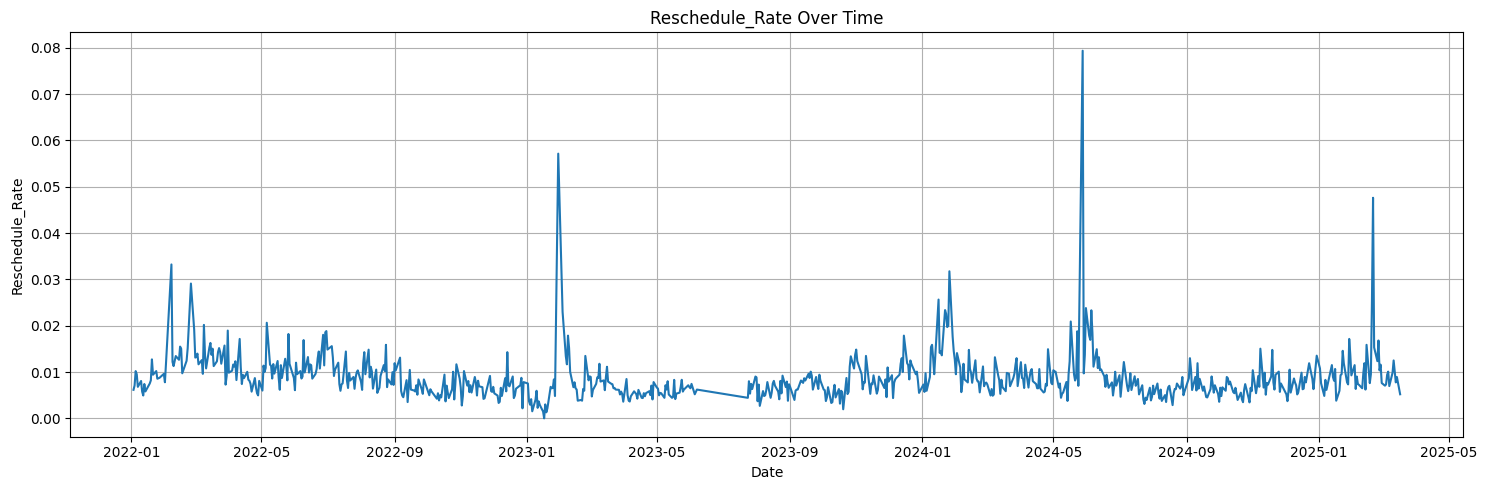

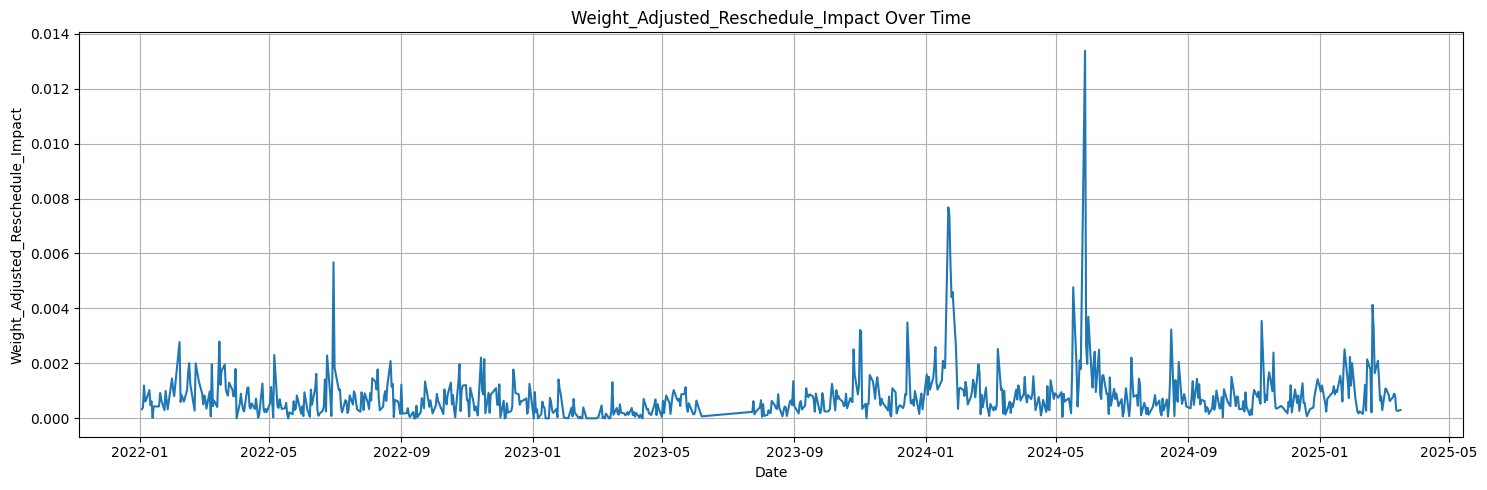

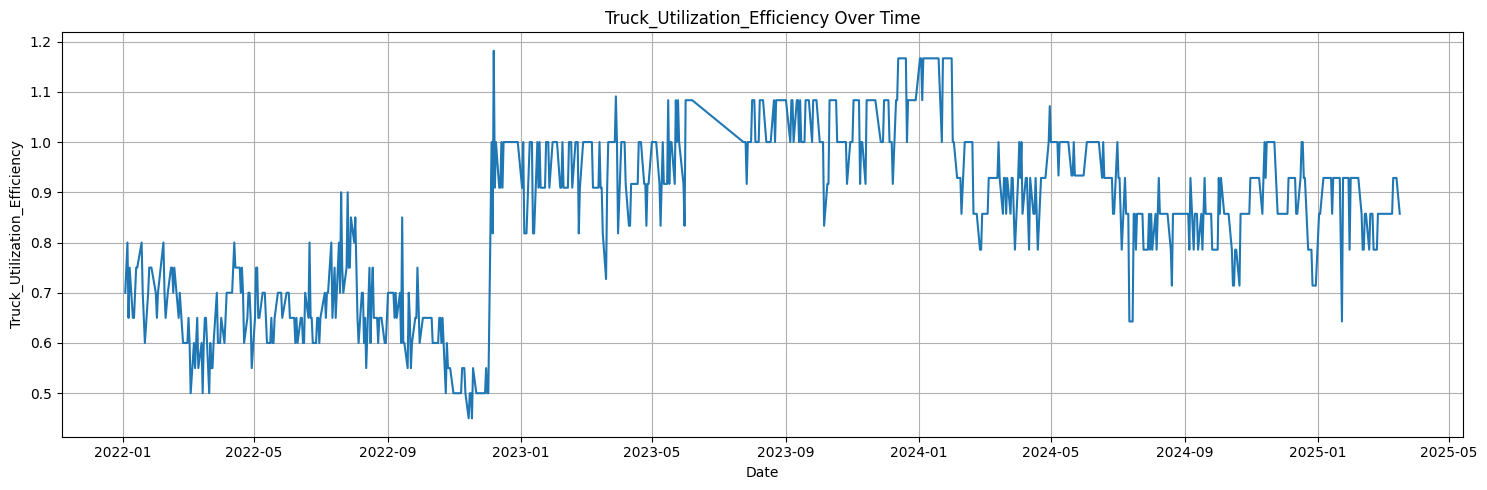

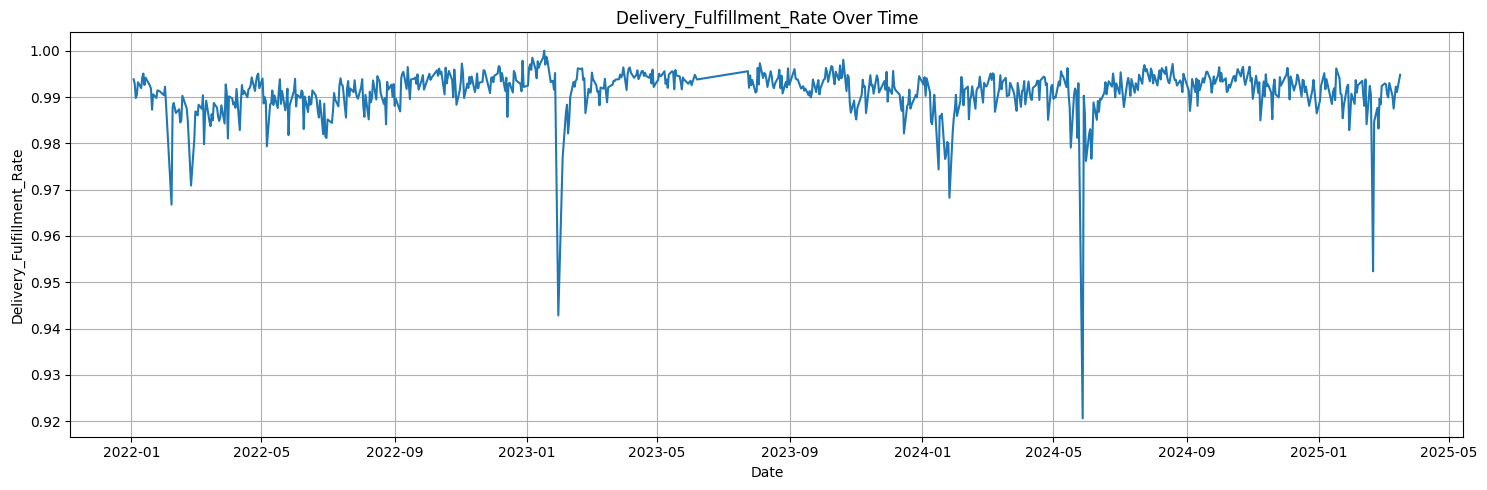

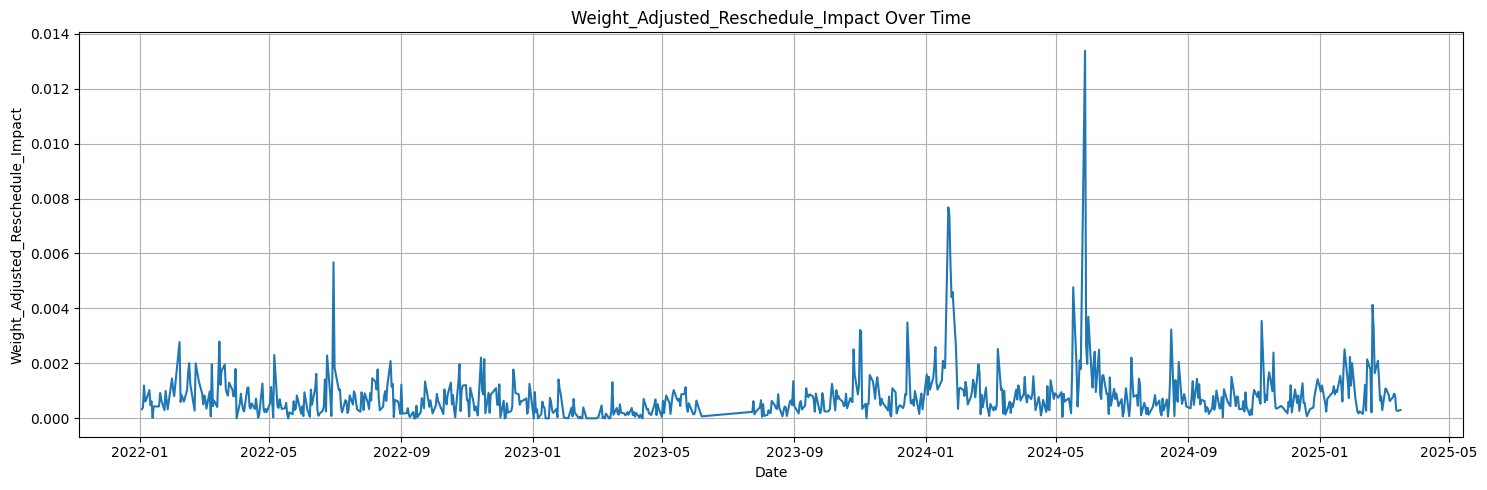

In [5]:
column_names = ['Reschedule_Rate', 'Weight_Adjusted_Reschedule_Impact', 'Truck_Utilization_Efficiency', 'Delivery_Fulfillment_Rate', 'Weight_Adjusted_Reschedule_Impact']
for column in column_names:
    ut.plot_time_series(df, column_name=column, title=f'{column} Over Time', xlabel='Date', ylabel=column)

Seems like dependent variables are stable, visually looks like homoskedasticity, no need for log transforming for now.

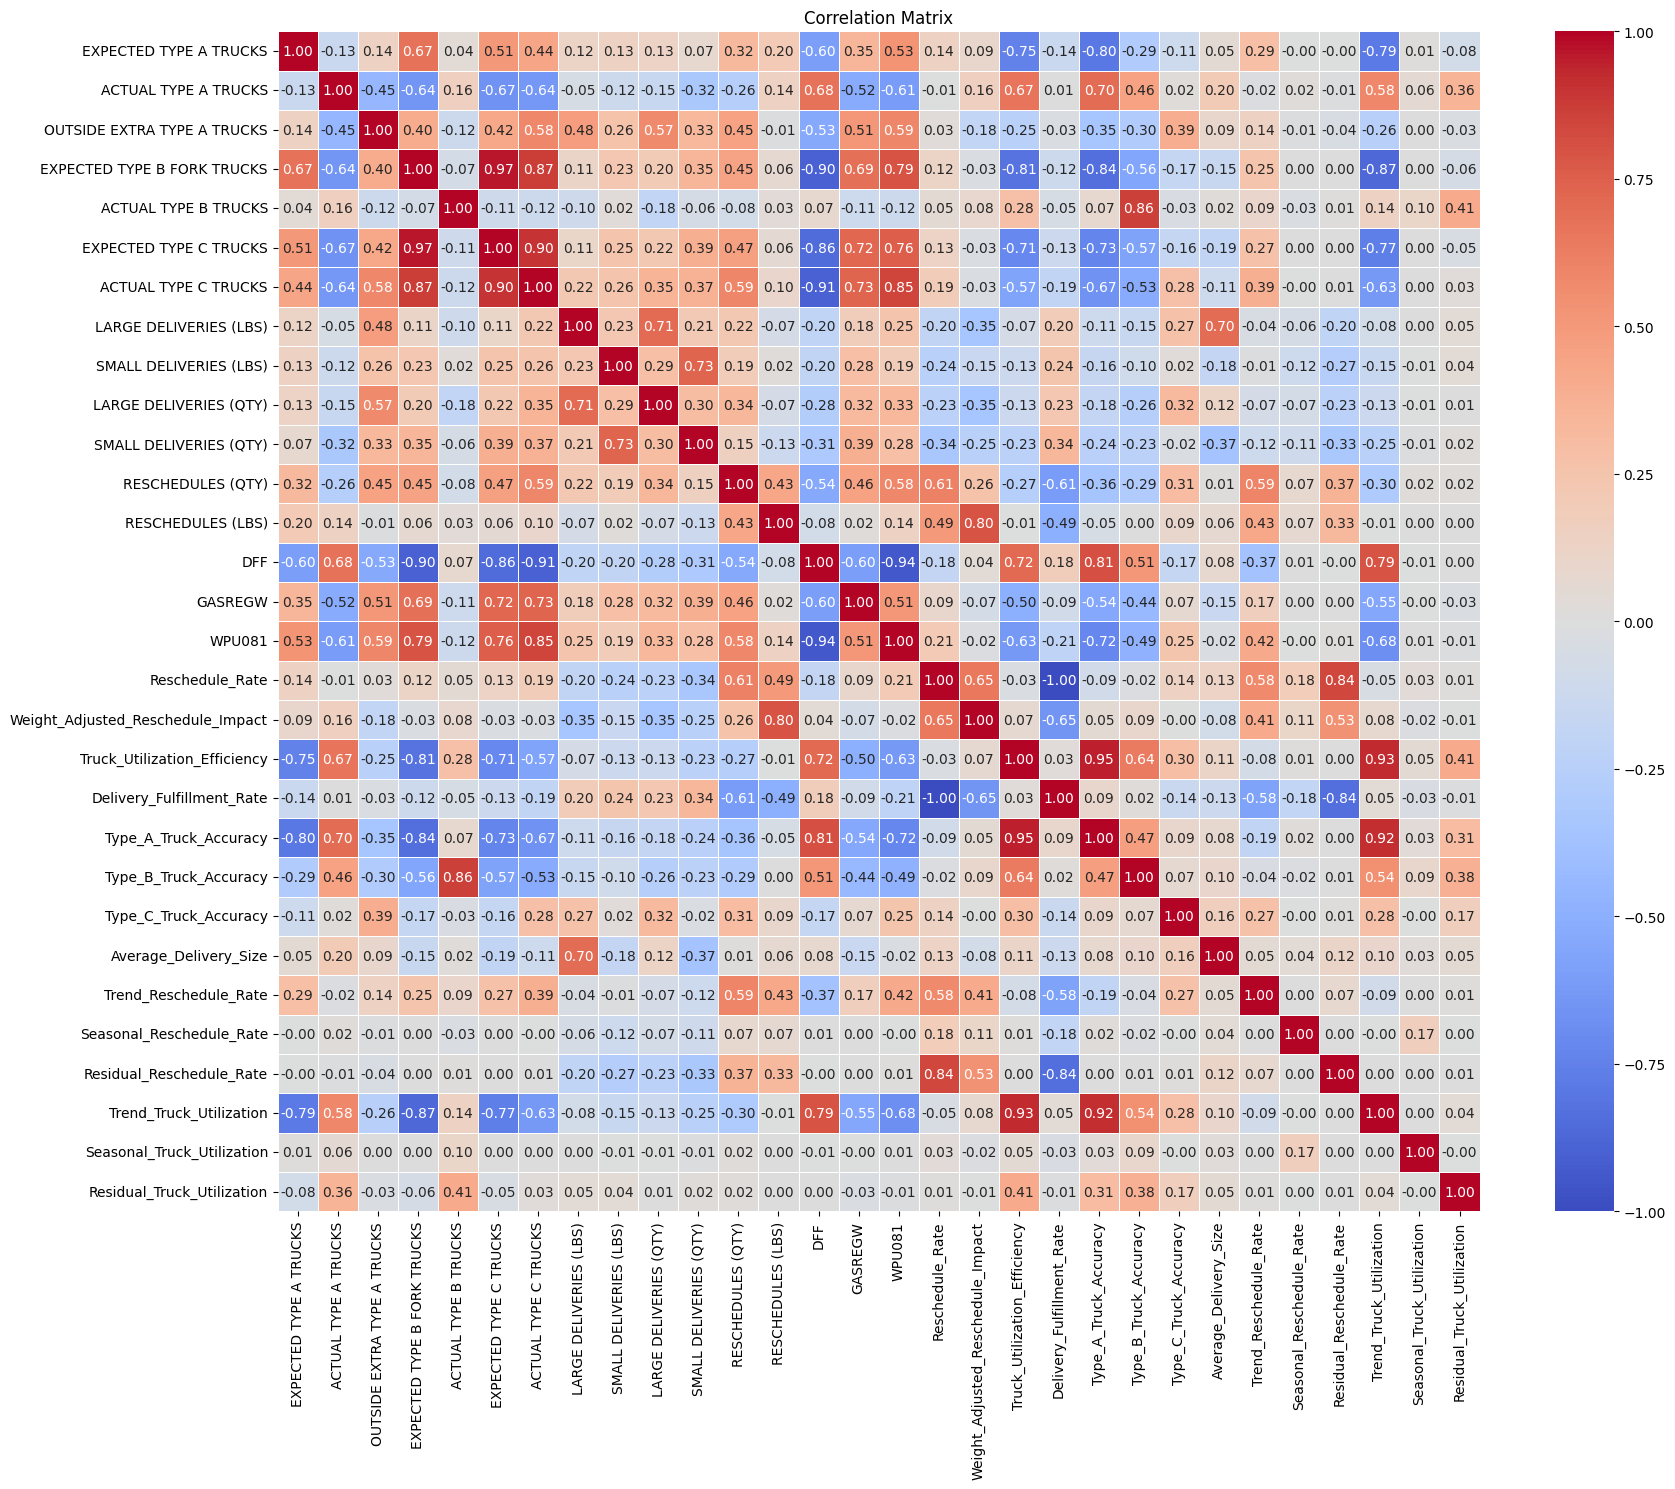

In [6]:
ut.plot_correlation_heatmap(df, method = 'pearson', columns=None, title='Correlation Matrix', figsize=(18, 15))

Let's move on to outlier detection

In [7]:
series_names = ['Reschedule_Rate', 'Truck_Utilization_Efficiency', 'Delivery_Fulfillment_Rate', 'Weight_Adjusted_Reschedule_Impact', 'RESCHEDULES (QTY)', 'RESCHEDULES (LBS)', 'EXPECTED TYPE A TRUCKS', 'EXPECTED TYPE B FORK TRUCKS', 'EXPECTED TYPE C TRUCKS', 'ACTUAL TYPE A TRUCKS', 'ACTUAL TYPE B TRUCKS', 'ACTUAL TYPE C TRUCKS', 'Type_A_Truck_Accuracy', 'Type_B_Truck_Accuracy', 'Type_C_Truck_Accuracy', 'LARGE DELIVERIES (QTY)', 'SMALL DELIVERIES (QTY)', 'LARGE DELIVERIES (LBS)', 'SMALL DELIVERIES (LBS)', 'WPU081', 'GASREGW', 'DFF']

for series in series_names:
    ut.identify_outliers_iqr(df[series], series_name = series, multiplier=1.5)

Identified 35 potential outliers for 'Reschedule_Rate' using IQR method (multiplier=1.5). Bounds: (-0.0004, 0.0165)
Identified 0 potential outliers for 'Truck_Utilization_Efficiency' using IQR method (multiplier=1.5). Bounds: (0.2857, 1.4286)
Identified 35 potential outliers for 'Delivery_Fulfillment_Rate' using IQR method (multiplier=1.5). Bounds: (0.9835, 1.0004)
Identified 40 potential outliers for 'Weight_Adjusted_Reschedule_Impact' using IQR method (multiplier=1.5). Bounds: (-0.0007, 0.0020)
Identified 15 potential outliers for 'RESCHEDULES (QTY)' using IQR method (multiplier=1.5). Bounds: (-0.5000, 11.5000)
Identified 22 potential outliers for 'RESCHEDULES (LBS)' using IQR method (multiplier=1.5). Bounds: (-9059.0000, 27113.0000)
Identified 0 potential outliers for 'EXPECTED TYPE A TRUCKS' using IQR method (multiplier=1.5). Bounds: (6.0000, 54.0000)
Identified 0 potential outliers for 'EXPECTED TYPE B FORK TRUCKS' using IQR method (multiplier=1.5). Bounds: (4.5000, 16.5000)
Ident

Identified 35 potential outliers for 'Reschedule_Rate' using IQR method (multiplier=1.5). Bounds: (-0.0004, 0.0165)


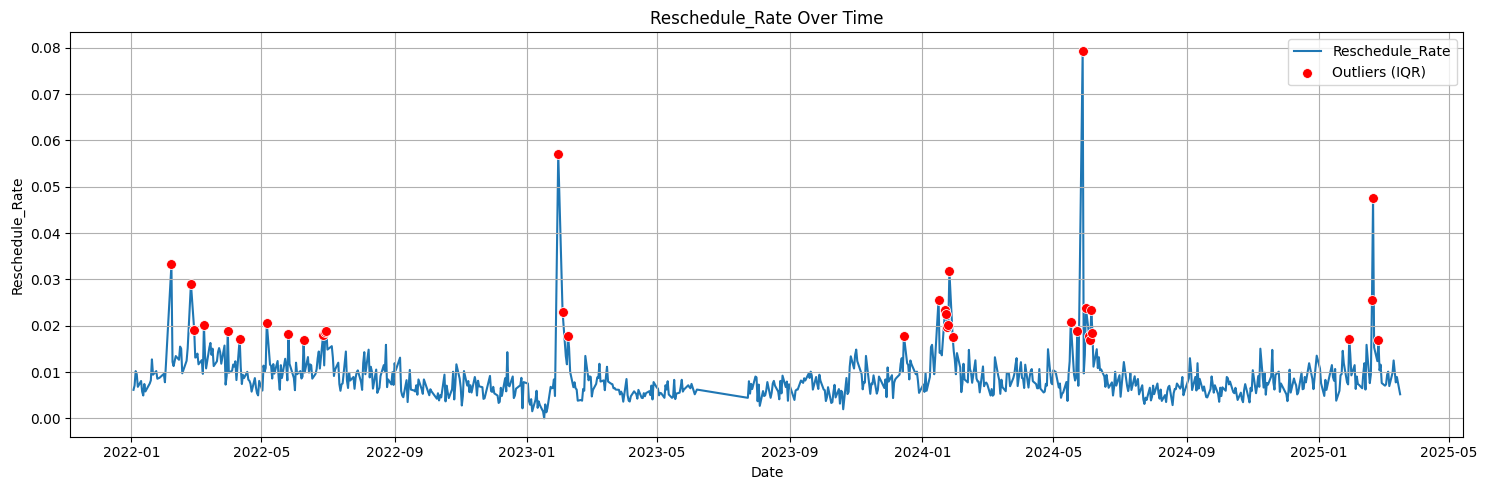

Identified 40 potential outliers for 'Weight_Adjusted_Reschedule_Impact' using IQR method (multiplier=1.5). Bounds: (-0.0007, 0.0020)


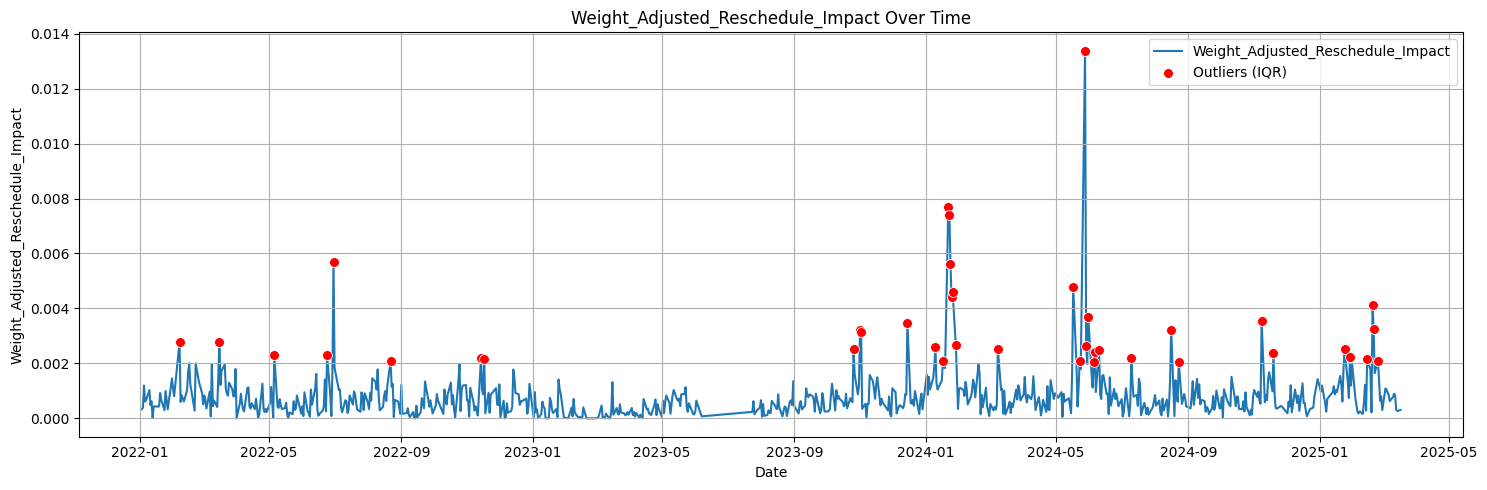

Identified 164 potential outliers for 'ACTUAL TYPE C TRUCKS' using IQR method (multiplier=1.5). Bounds: (-1.5000, 10.5000)


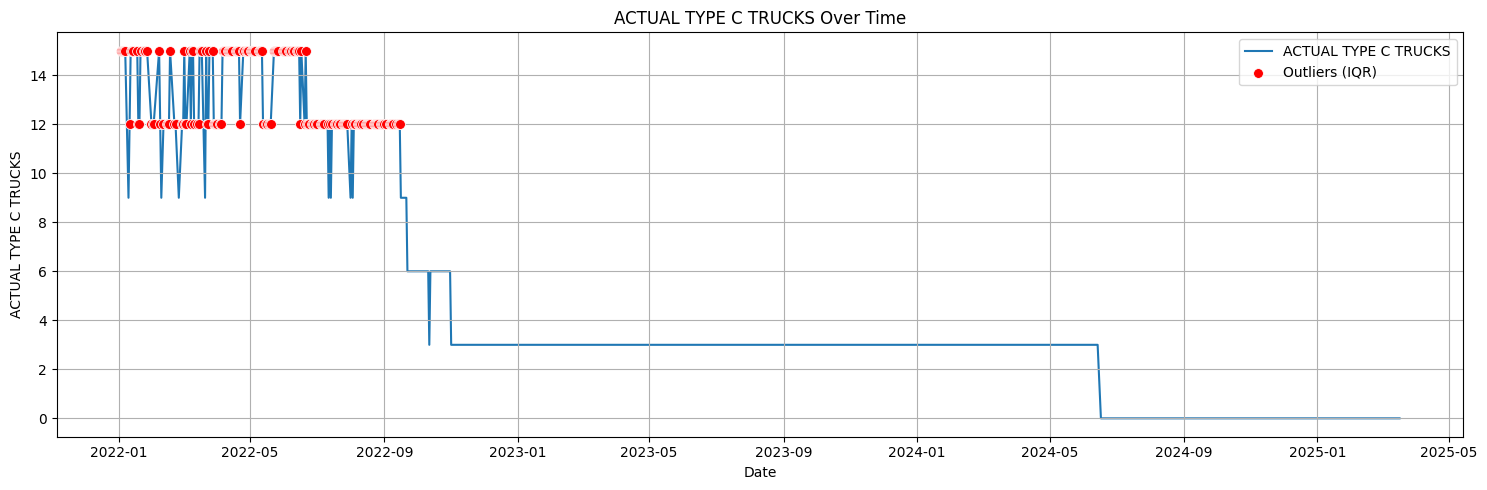

Identified 129 potential outliers for 'Type_C_Truck_Accuracy' using IQR method (multiplier=1.5). Bounds: (1.0000, 1.0000)


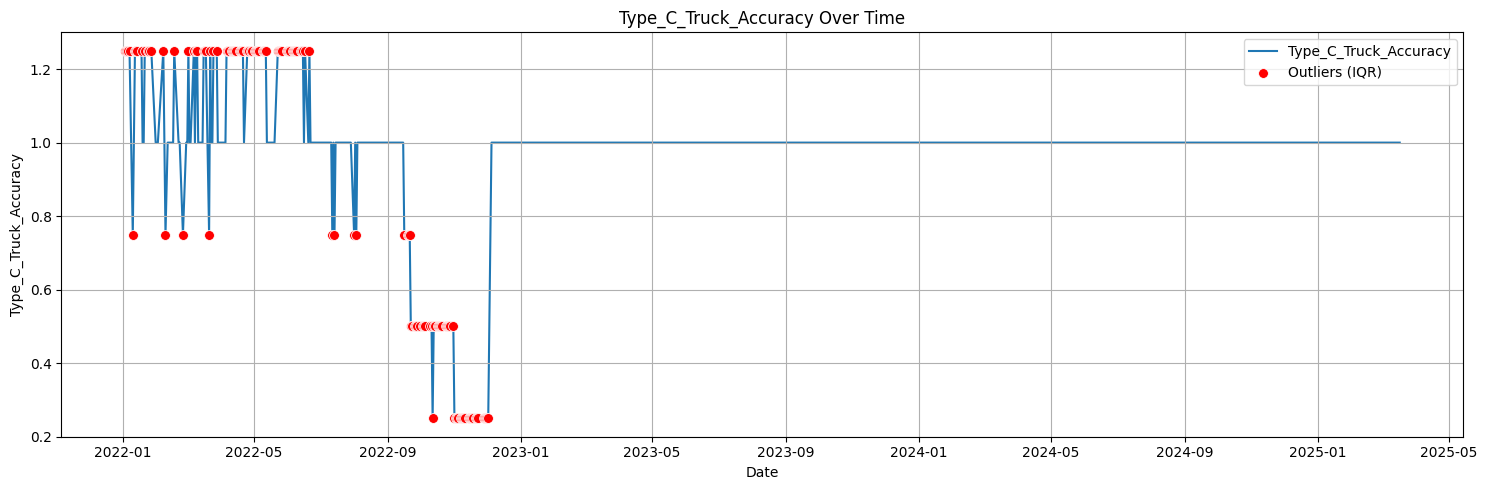

Identified 97 potential outliers for 'WPU081' using IQR method (multiplier=1.5). Bounds: (205.1370, 329.5850)


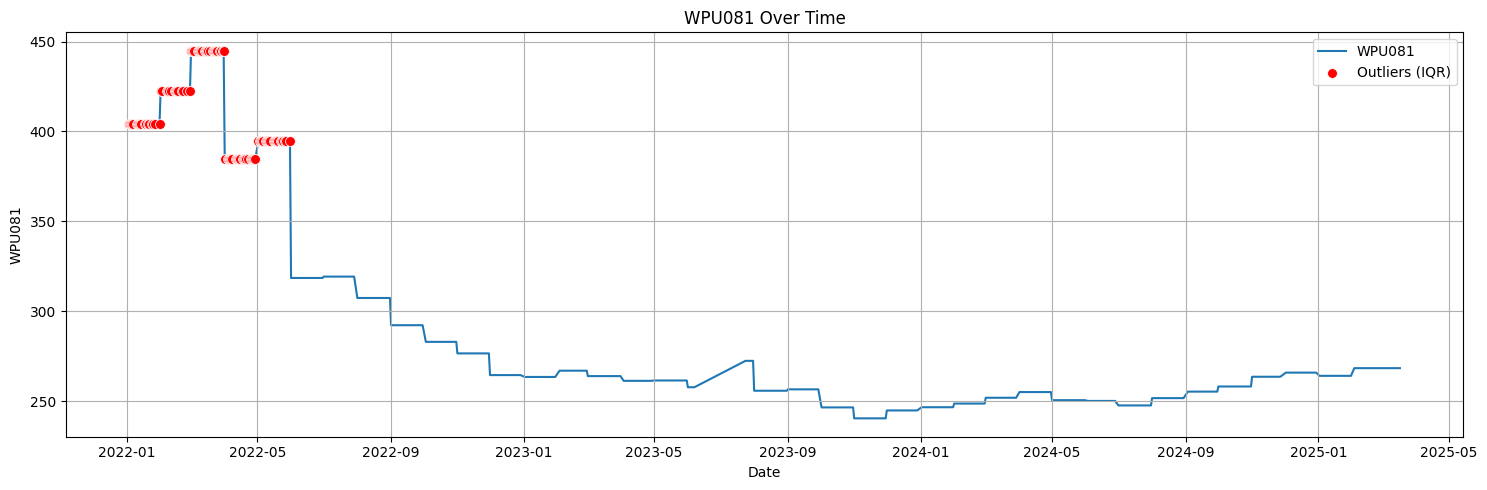

Identified 38 potential outliers for 'GASREGW' using IQR method (multiplier=1.5). Bounds: (2.4365, 4.5685)


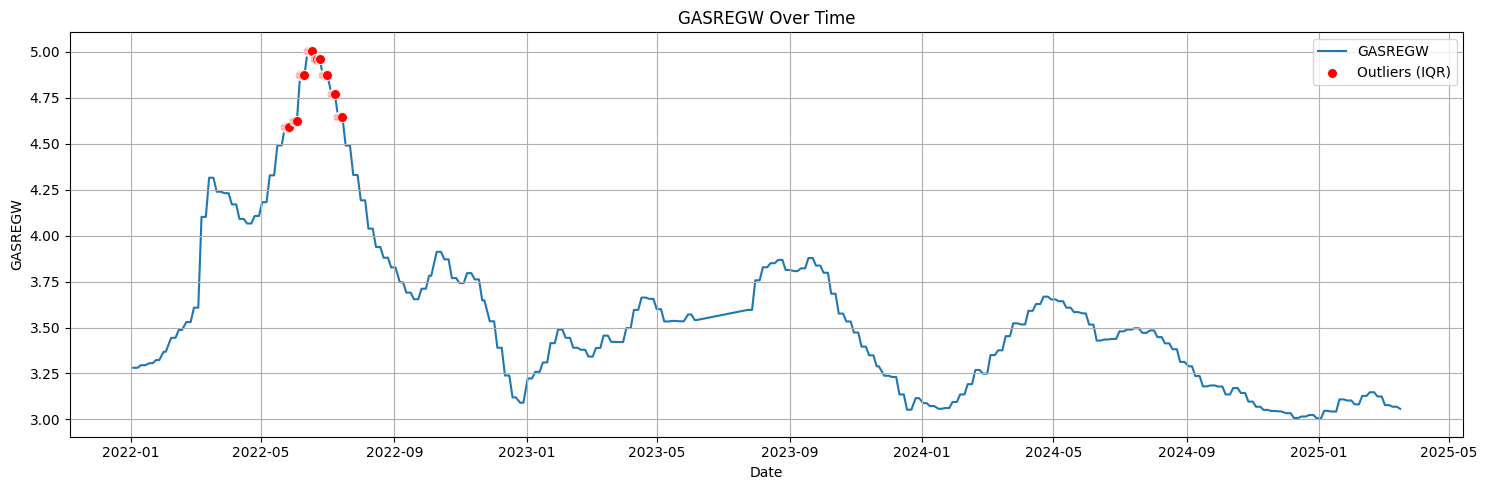

In [8]:
outlier_columns = ['Reschedule_Rate', 'Weight_Adjusted_Reschedule_Impact', 'ACTUAL TYPE C TRUCKS', 'Type_C_Truck_Accuracy', 'WPU081', 'GASREGW']
for column in outlier_columns:
    ut.plot_series_with_outliers(df, column_name=column, title=f'{column} Over Time', xlabel='Date', ylabel=column)

So we decided to choose a few variables, and the results are quite interesting. Truck C's outliers, upon closer inspection on the dataframe itself, is just due to Truck C being phased out itself. Truck C needs to be on a close watch because it may not be reliable. 

As for reschedule impact, the metric itself is extremely low, indicating very low impact of rescheduling on the actual metric. This makes this metric not very worth looking at. Let's keep looking at rescheduling rate, because those reschedules could erode business trust and still be costly at the end of the day.

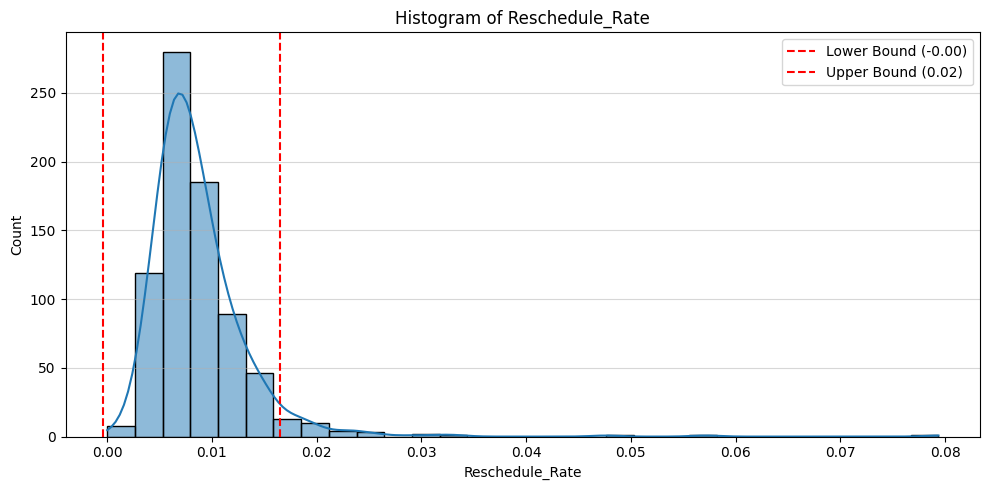

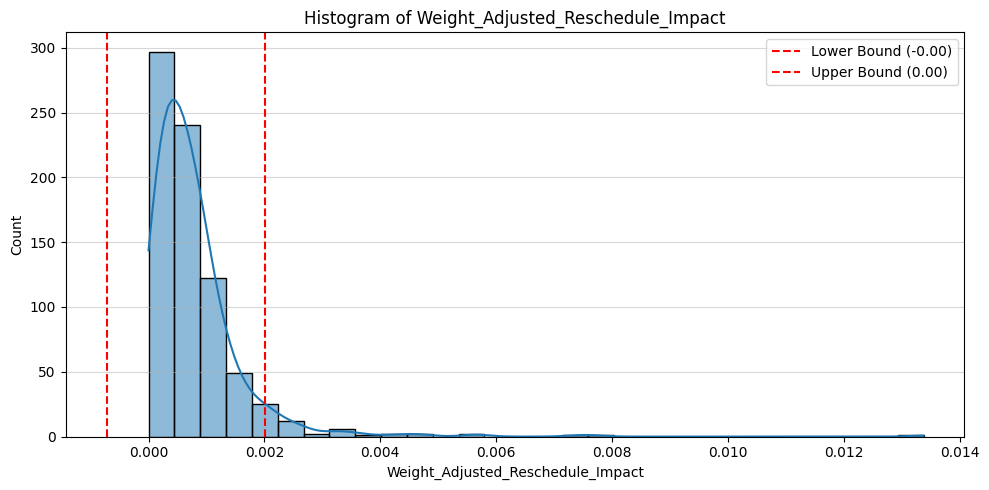

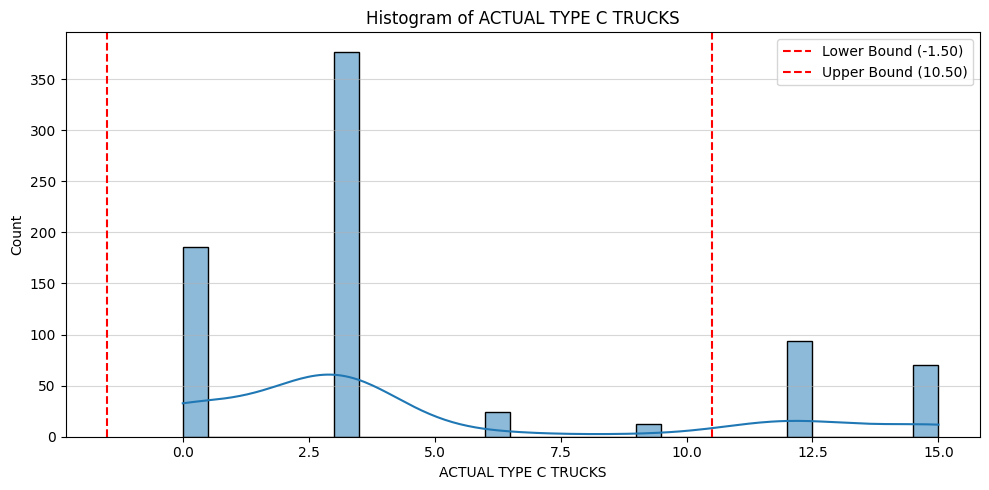

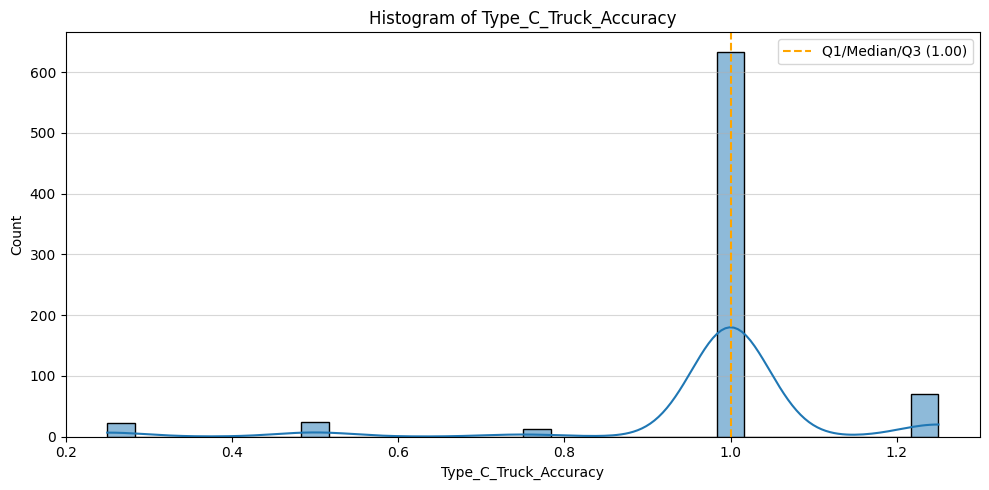

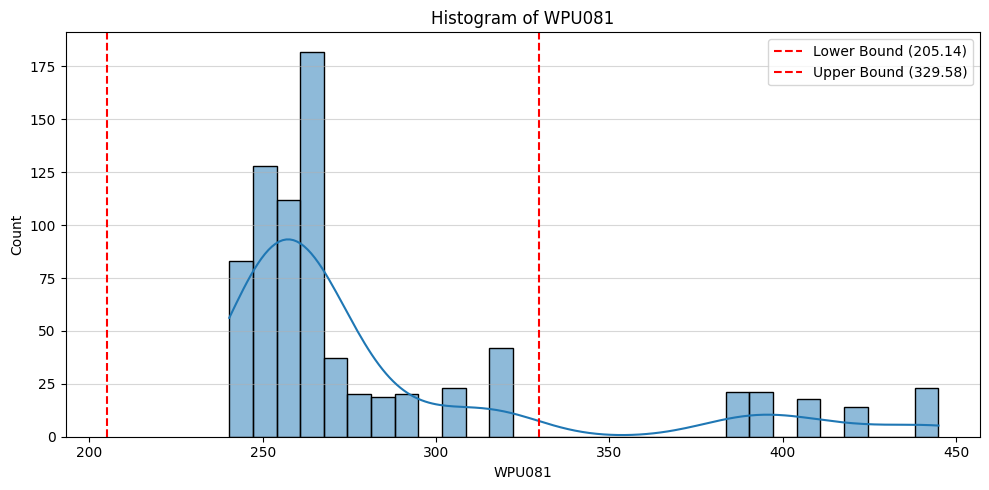

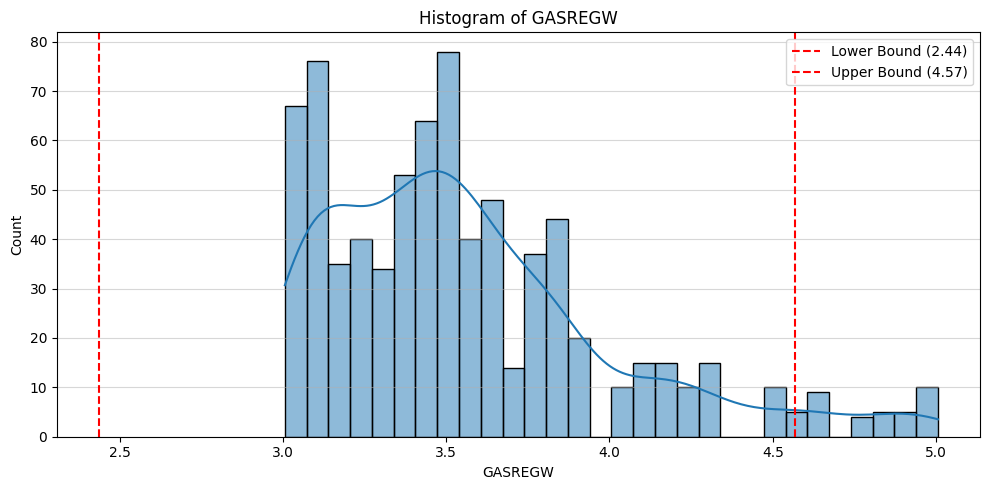

In [9]:
for col_name in outlier_columns: # Using 'col_name' for clarity
    ut.plot_histogram_with_outliers(df[col_name], series_name=col_name, multiplier=1.5, bins=30)

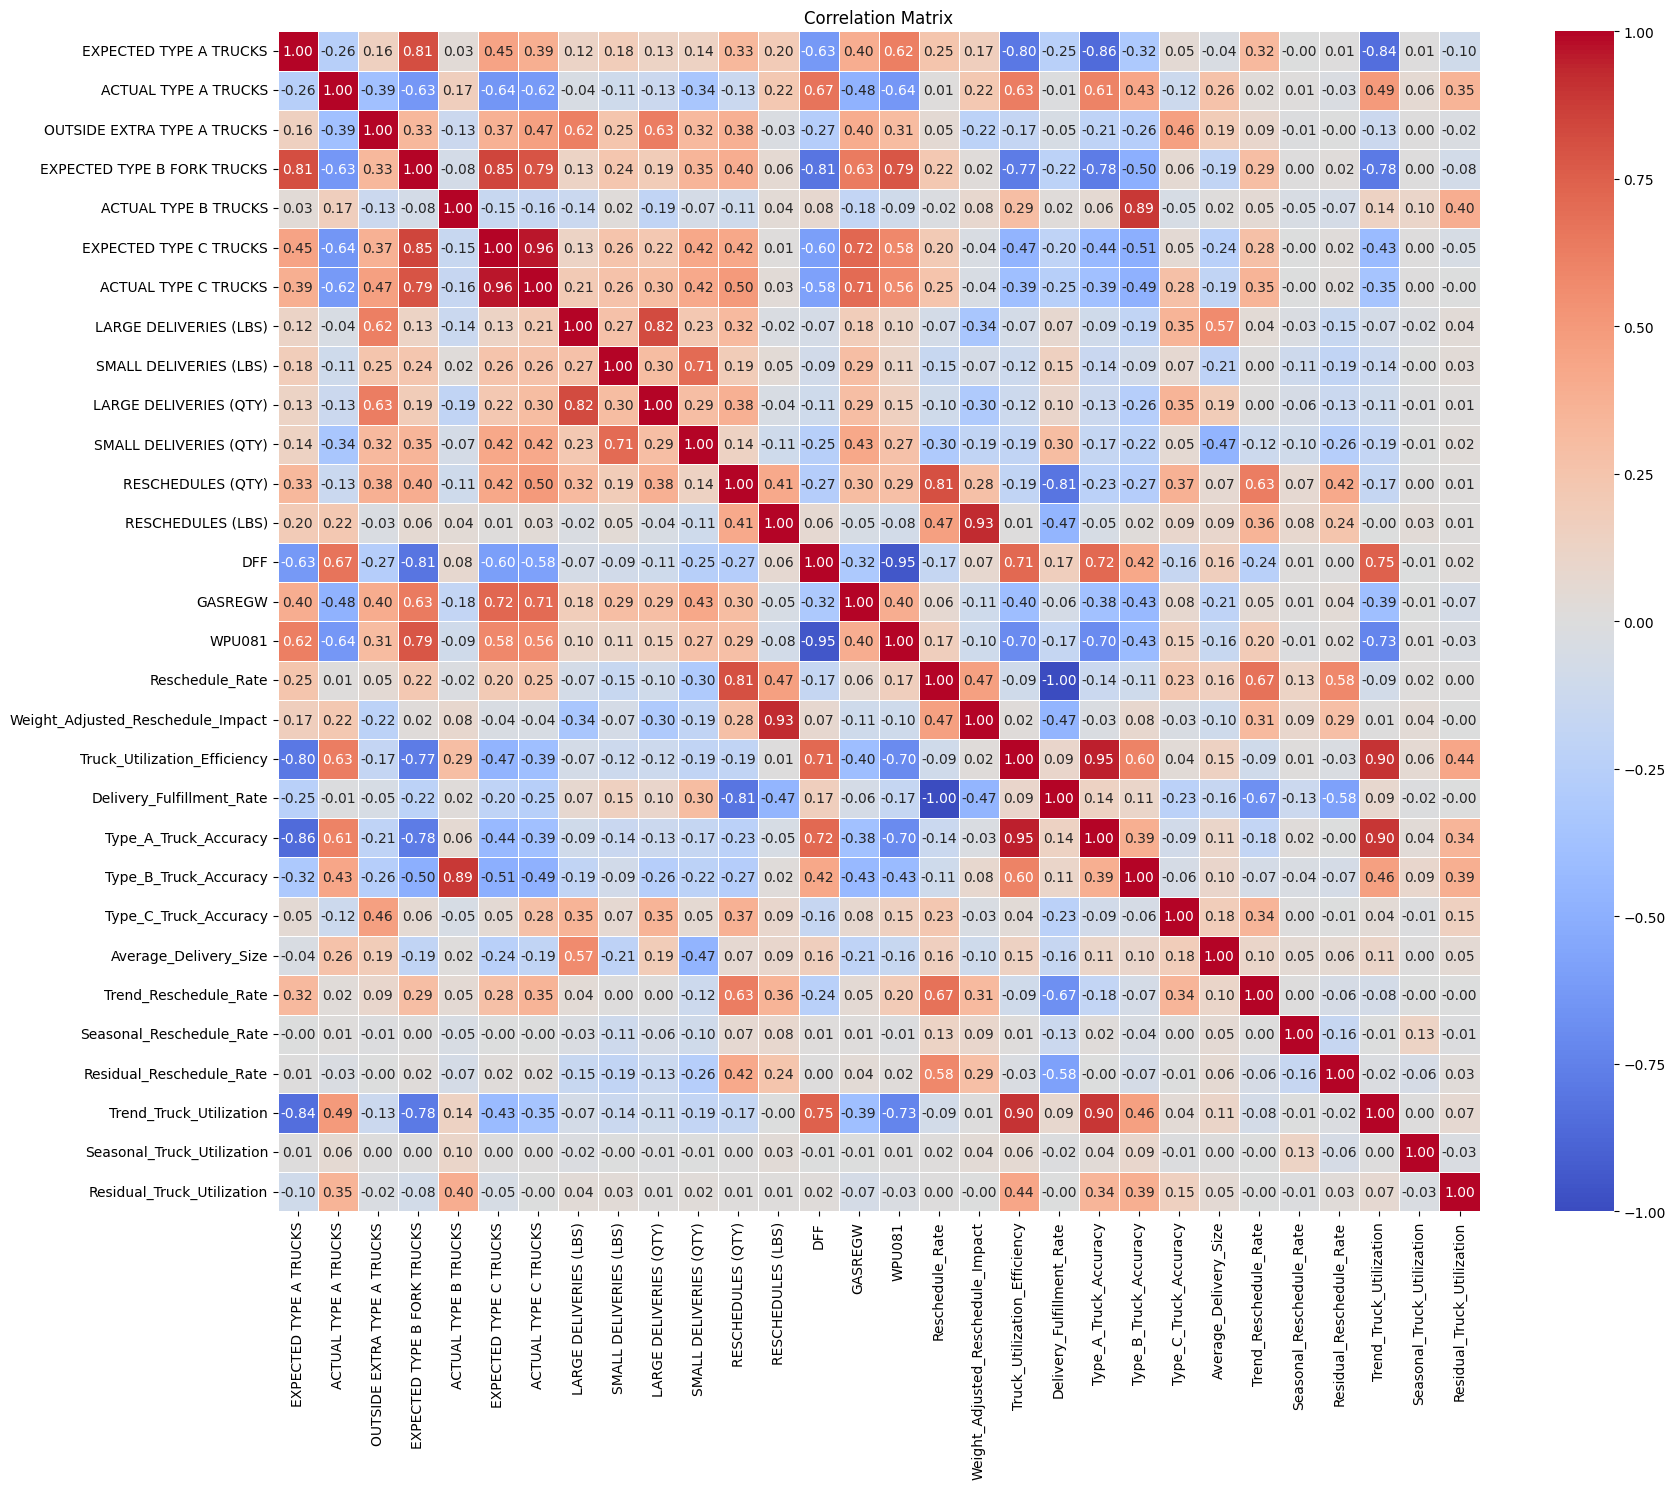

In [10]:
ut.plot_correlation_heatmap(df, method = 'spearman', columns=None, title='Correlation Matrix', figsize=(18, 15))

We know there's a lot of outliers and our data is a little weird. Here we try out spearman correlation, and we see that it's largely the same. Small deliveries are negatively correlated, meaning when there's more small deliveries, there tends to also be a lower reschedule rate. This would IMPLY that large deliveries are more prone to cancellations, but large deliveries are at -0.10, so it's a very very weak correlation. The more probable cause is that small deliveries reduce reschedule rate due to the amount of transactions being made and small deliveries having higher probability of going through.

We can consider a few predictors now(spearman):
Small Deliveries - -0.30
DFF - -0.17
WPU081 - 0.17
Actual Type C Trucks - 0.25
Trend Reschedule Rate - 0.67
Residual Reschedule Rate -0.58


Let's continue our EDA with stationarity analysis.

In [11]:
ut.run_stationarity_tests(df['Reschedule_Rate'], 'Reschedule_Rate')

--- Stationarity Tests for: Reschedule_Rate ---
ADF Test Results:
  ADF Statistic: -6.2136
  p-value: 0.0000
  Lags Used: 5
  Number of Observations: 757
  Critical Values:
	1%: -3.4390
	5%: -2.8654
	10%: -2.5688
  Conclusion: Likely Stationary (reject H0 at 5% level)

---
KPSS Test Results (stationarity around constant):
  KPSS Statistic: 0.2533
  p-value: 0.1000
  Lags Used: 15
  Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
  Conclusion: Likely Stationary around constant (fail to reject H0 at 5% level)
---------------------------------------



Reschedule Rate is Stationary! Great.

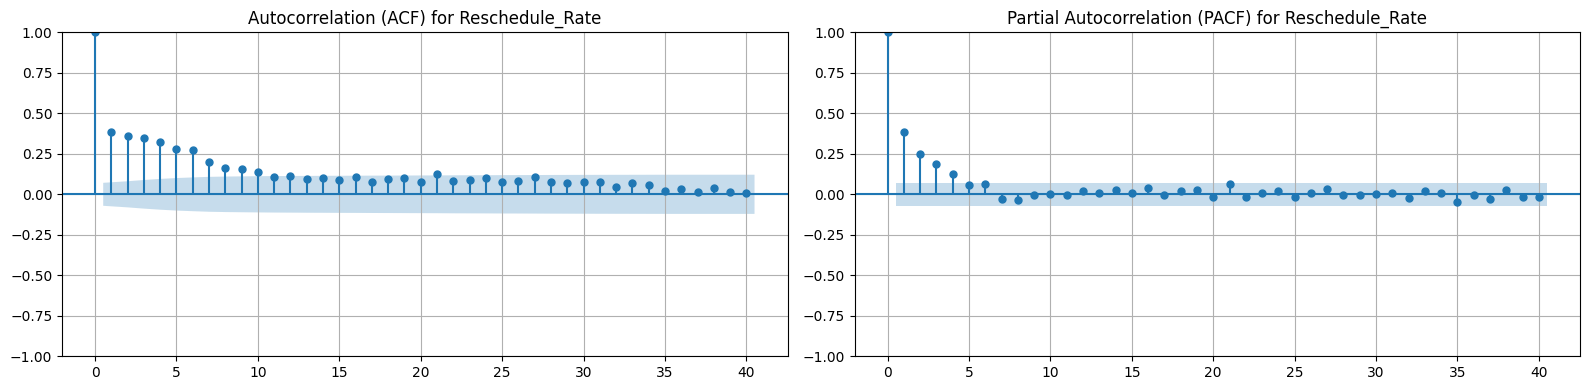

In [12]:
ut.plot_acf_pacf(df['Reschedule_Rate'], title_suffix='for Reschedule_Rate')

ACF (Left Plot)

Gradual Decay Pattern: The autocorrelation shows significant positive values that slowly decrease across multiple lags (roughly 10-12 periods)
This gradual decay suggests "memory." Reschedule rates in one period influence rates for several periods afterward

PACF (Right Plot)

Sharp Cutoff After Lag 4: There are significant spikes at lags 1-4, then values fall within the significance bands
This pattern is characteristic of an AR(4) process - the reschedule rate is directly influenced by its values from the previous 4 time periods, but not by earlier periods directly

Let's test stationarity on everything else now.

We can consider a few predictors now(spearman):
Small Deliveries - -0.30
DFF - -0.17
WPU081 - 0.17
Actual Type C Trucks - 0.25
Trend Reschedule Rate - 0.67
Residual Reschedule Rate -0.58

In [13]:
# Stationarity Test for the selected predictors
for col_name in df.columns[1:]:  # Skip the first column (Date) for stationarity tests
    ut.run_stationarity_tests(df[col_name], col_name)

--- Stationarity Tests for: ACTUAL TYPE A TRUCKS ---
ADF Test Results:
  ADF Statistic: -2.0357
  p-value: 0.2711
  Lags Used: 13
  Number of Observations: 749
  Critical Values:
	1%: -3.4391
	5%: -2.8654
	10%: -2.5688
  Conclusion: Likely Non-Stationary (fail to reject H0 at 5% level)

---
KPSS Test Results (stationarity around constant):
  KPSS Statistic: 3.4135
  p-value: 0.0100
  Lags Used: 17
  Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
  KPSS Statistic: 3.4135
  p-value: 0.0100
  Lags Used: 17
  Critical Values:
  Conclusion: Likely Non-Stationary around trend too (reject H0 at 5% level)
---------------------------------------

--- Stationarity Tests for: OUTSIDE EXTRA TYPE A TRUCKS ---
ADF Test Results:
  ADF Statistic: -2.4494
  p-value: 0.1283
  Lags Used: 9
  Number of Observations: 753
  Critical Values:
	1%: -3.4391
	5%: -2.8654
	10%: -2.5688
  Conclusion: Likely Non-Stationary (fail to reject H0 at 5% level)

---
KPSS Test Results (stationarity aro

In [14]:
# List of variables to difference
variables_to_difference = [
    'ACTUAL TYPE A TRUCKS', 'OUTSIDE EXTRA TYPE A TRUCKS', 'EXPECTED TYPE B FORK TRUCKS',
    'EXPECTED TYPE C TRUCKS', 'SMALL DELIVERIES (LBS)', 'LARGE DELIVERIES (QTY)',
    'SMALL DELIVERIES (QTY)', 'RESCHEDULES (QTY)', 'RESCHEDULES (LBS)', 'GASREGW',
    'Weight_Adjusted_Reschedule_Impact', 'Truck_Utilization_Efficiency',
    'Type_A_Truck_Accuracy', 'Type_B_Truck_Accuracy', 'Average_Delivery_Size',
    'Trend_Truck_Utilization'
]

# Difference the variables and replace the original columns
for var in variables_to_difference:
    diff_col_name = f"{var}_diff"
    df[diff_col_name] = df[var].diff()
    df.drop(columns=[var], inplace=True)
    df.rename(columns={diff_col_name: var}, inplace=True)


In [15]:
# Create differenced versions of the non-stationary variables
df['DFF_diff'] = df['DFF'].diff()
df['WPU081_diff'] = df['WPU081'].diff()
df['ACTUAL_TYPE_C_TRUCKS_diff'] = df['ACTUAL TYPE C TRUCKS'].diff()

# Replace the original columns with their differenced versions
df.drop(columns=['DFF', 'WPU081', 'ACTUAL TYPE C TRUCKS'], inplace=True)


Now we can use these differenced variables in regression models, let's just double check for stationarity just to make sure.

In [16]:
Differenced_Col = ['DFF_diff', 'WPU081_diff', 'ACTUAL_TYPE_C_TRUCKS_diff'] + variables_to_difference
for col_name in Differenced_Col:
    ut.run_stationarity_tests(df[col_name], col_name)

--- Stationarity Tests for: DFF_diff ---
ADF Test Results:
  ADF Statistic: -27.8056
  p-value: 0.0000
  Lags Used: 0
  Number of Observations: 761
  Critical Values:
	1%: -3.4390
	5%: -2.8653
	10%: -2.5688
  Conclusion: Likely Stationary (reject H0 at 5% level)

---
KPSS Test Results (stationarity around constant):
  KPSS Statistic: 1.3124
  p-value: 0.0100
  Lags Used: 2
  Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
  KPSS Statistic: 1.3124
  p-value: 0.0100
  Lags Used: 2
  Critical Values:
  Conclusion: Likely Non-Stationary around trend too (reject H0 at 5% level)
---------------------------------------

--- Stationarity Tests for: WPU081_diff ---
ADF Test Results:
  ADF Statistic: -27.6063
  p-value: 0.0000
  Lags Used: 0
  Number of Observations: 761
  Critical Values:
	1%: -3.4390
	5%: -2.8653
	10%: -2.5688
  Conclusion: Likely Stationary (reject H0 at 5% level)

---
KPSS Test Results (stationarity around constant):
  KPSS Statistic: 0.3548
  p-value: 0.

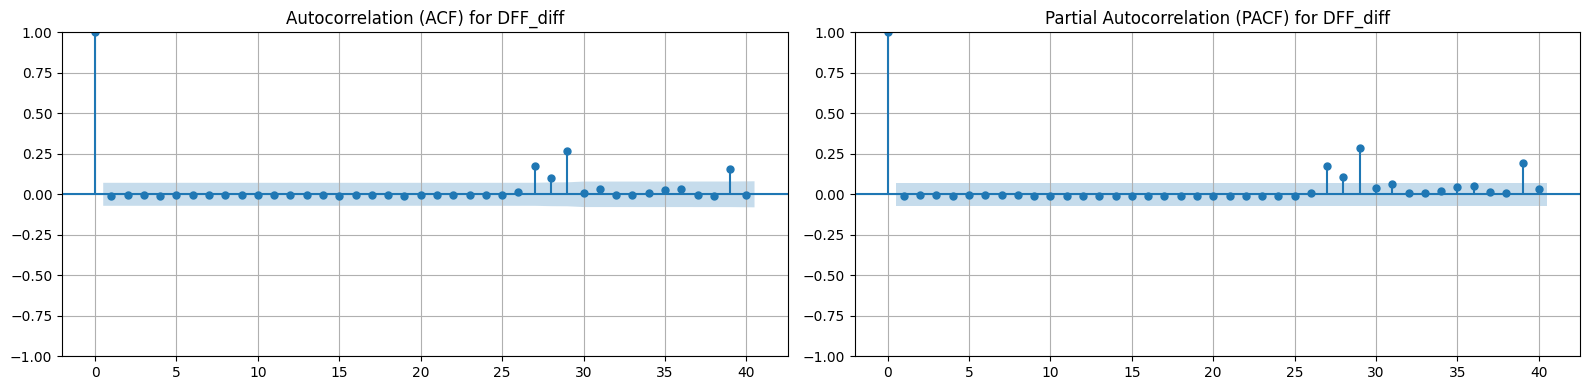

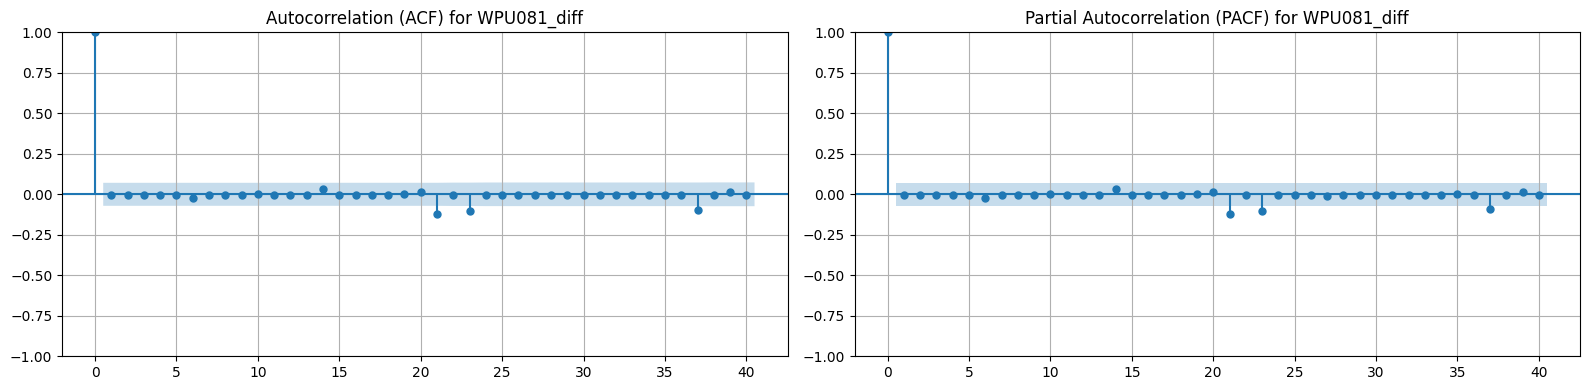

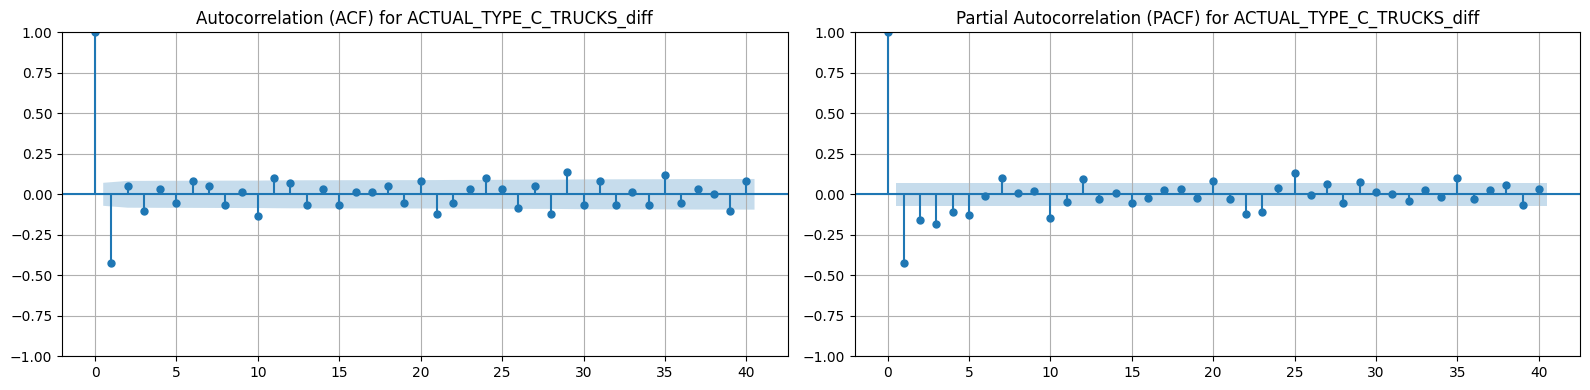

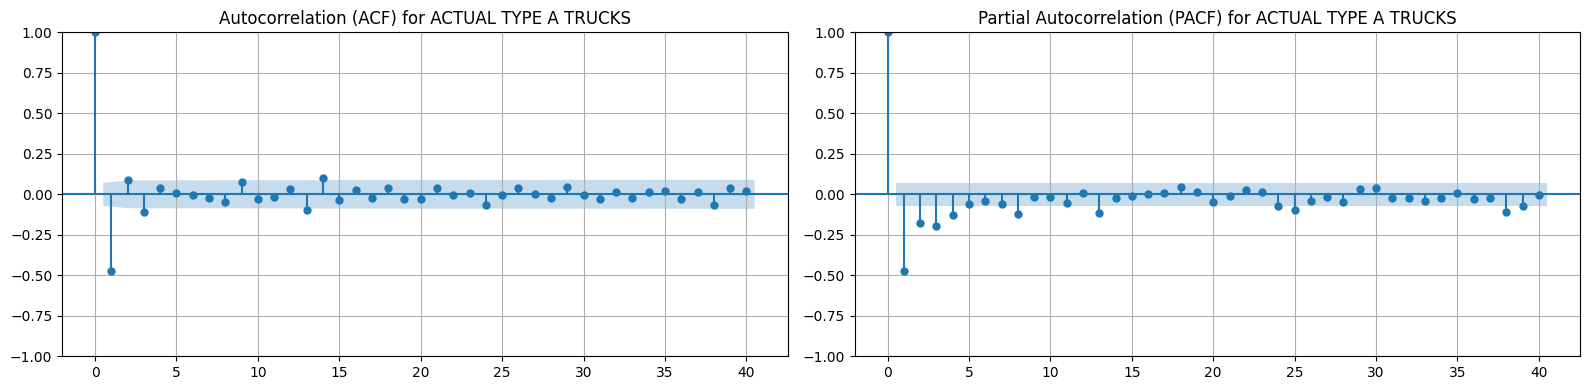

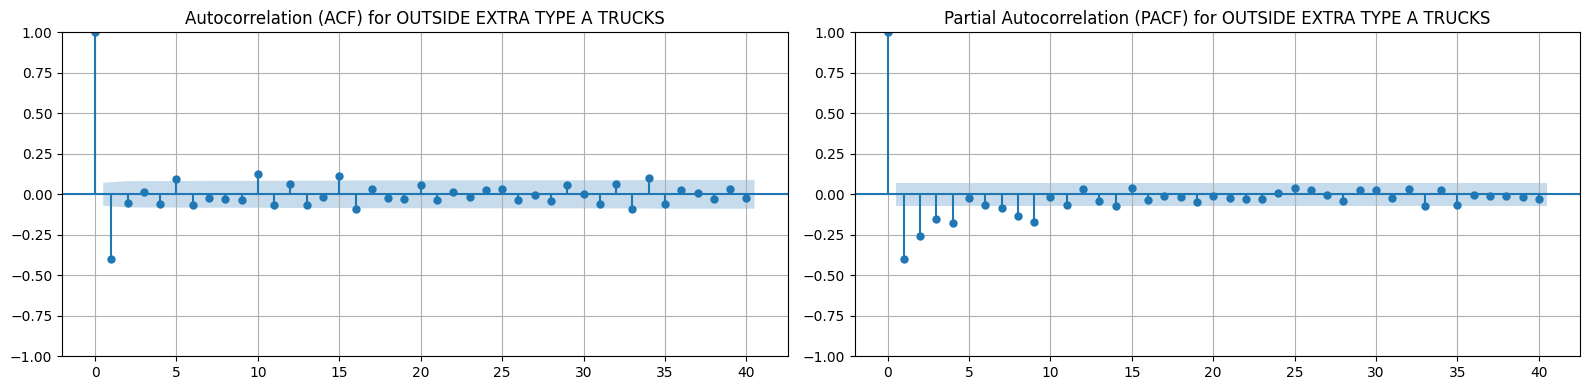

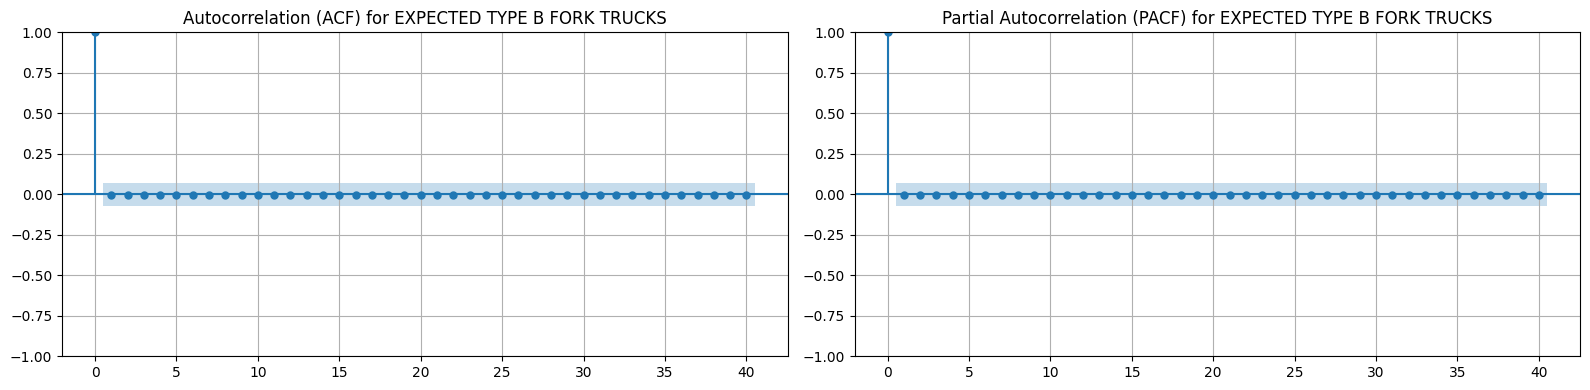

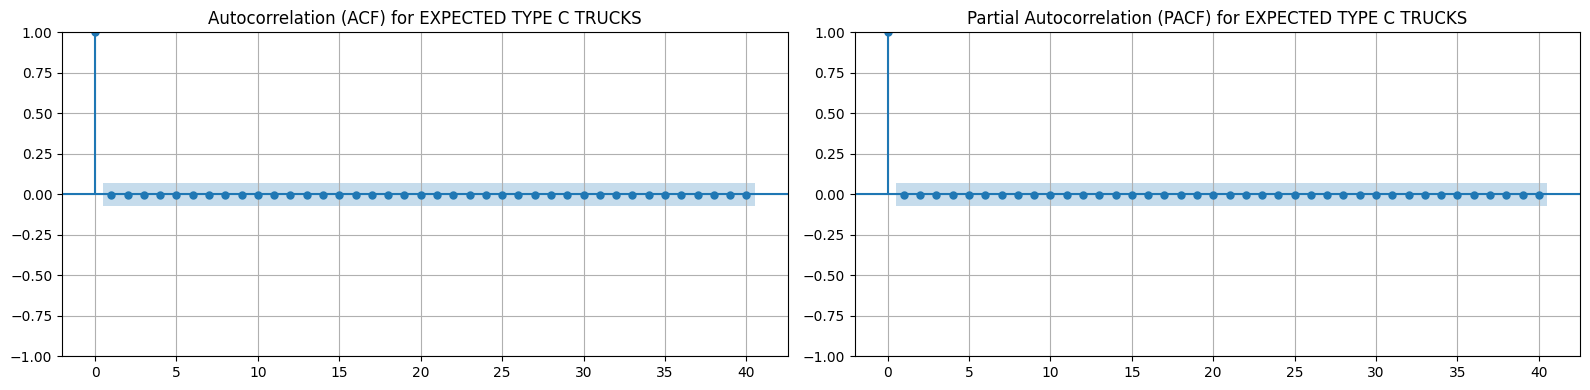

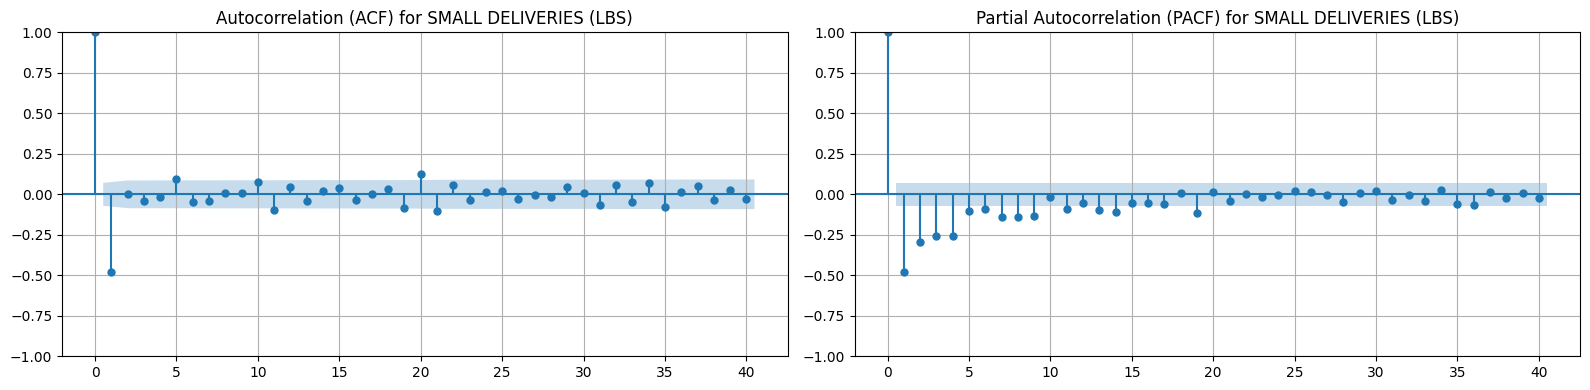

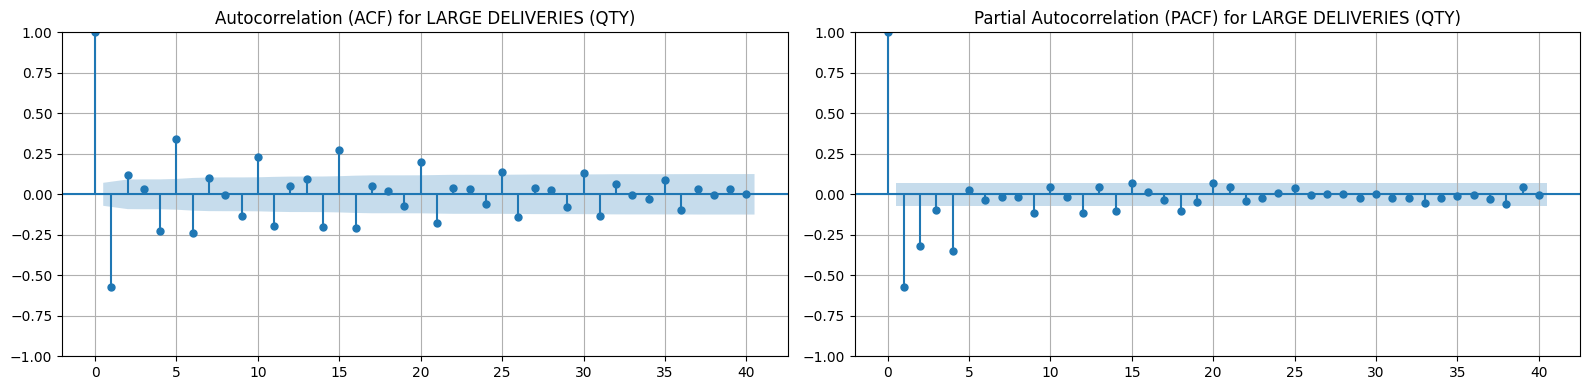

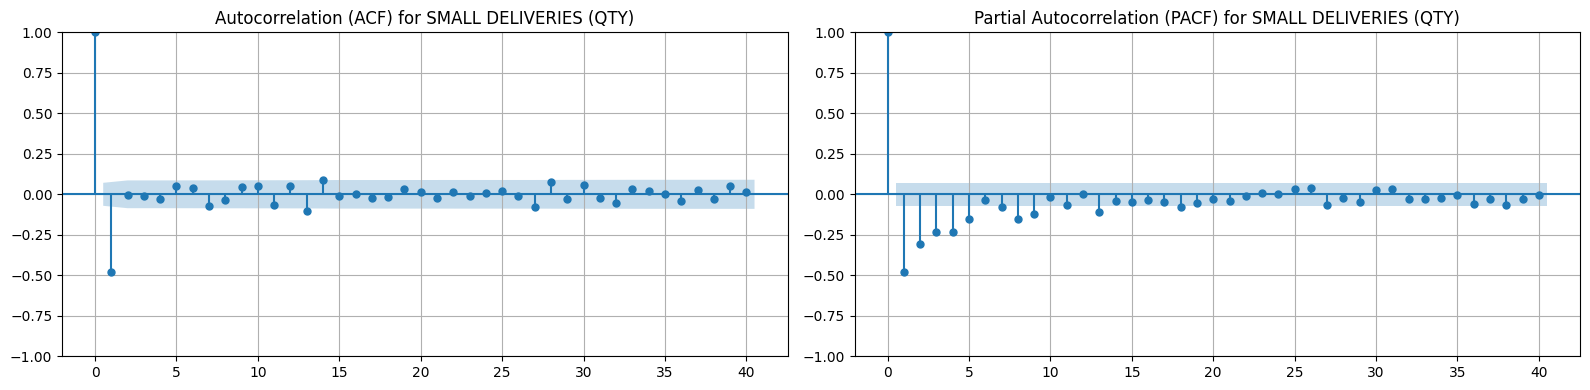

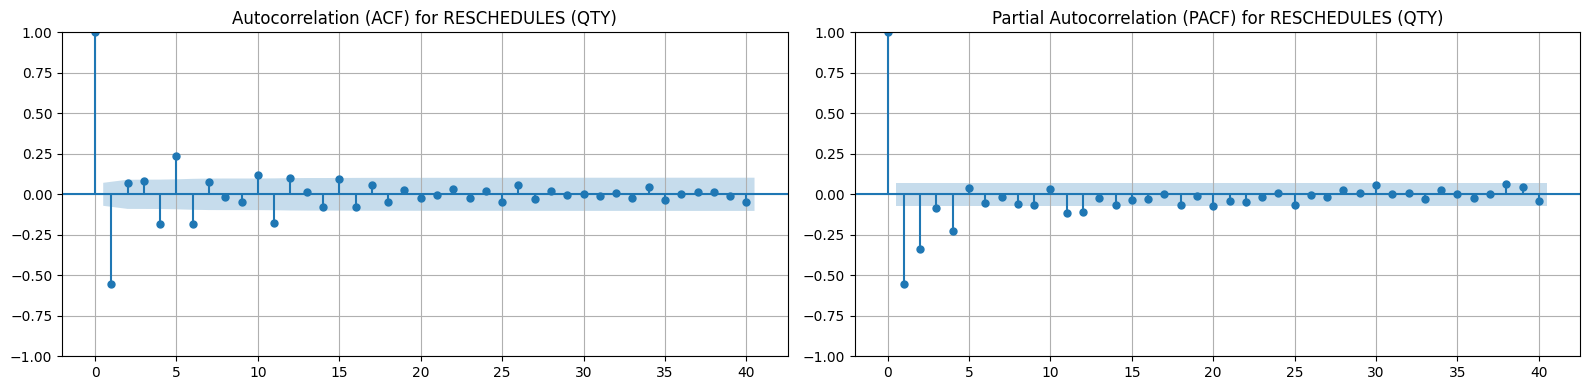

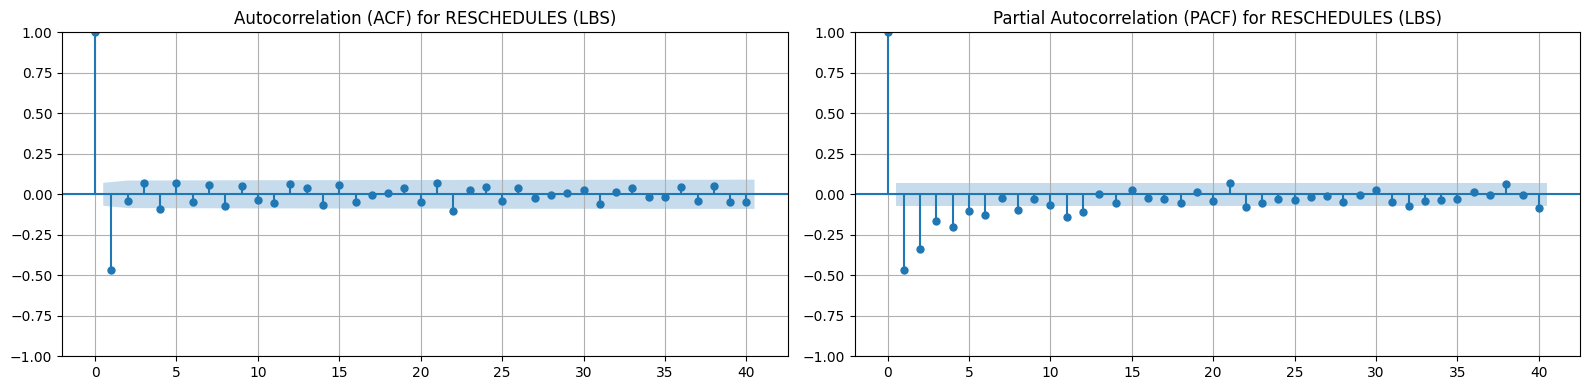

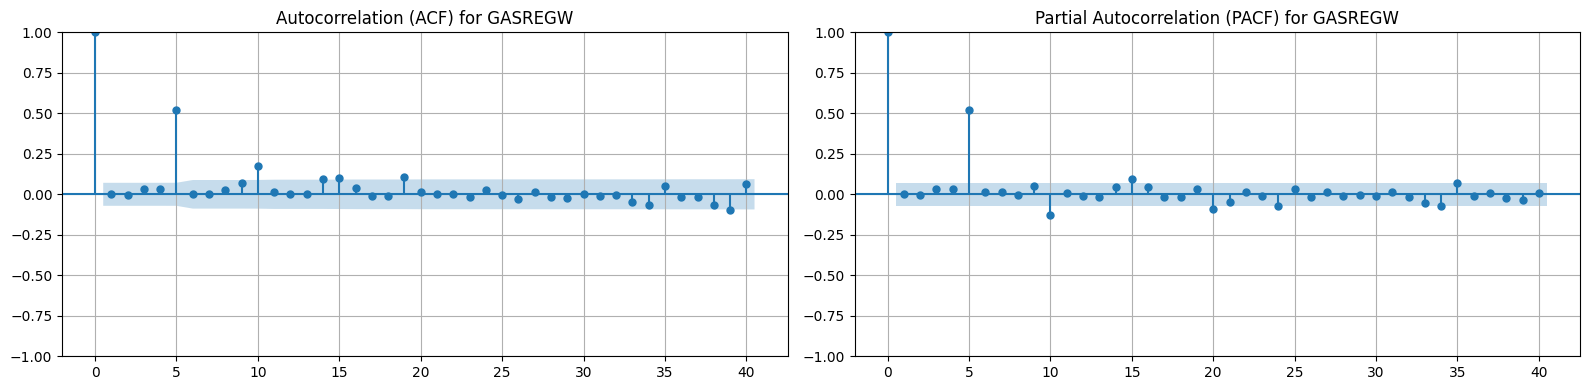

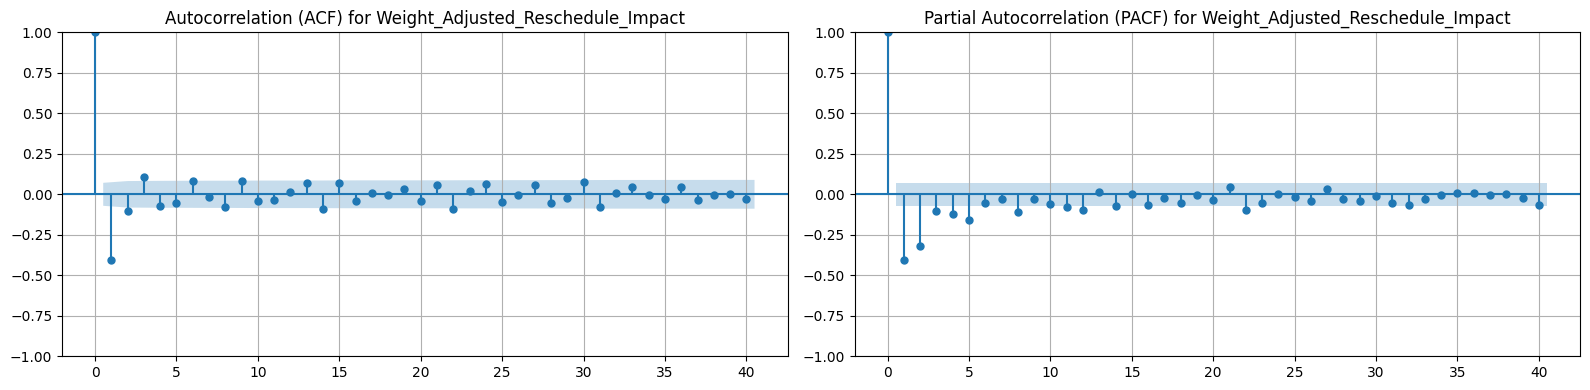

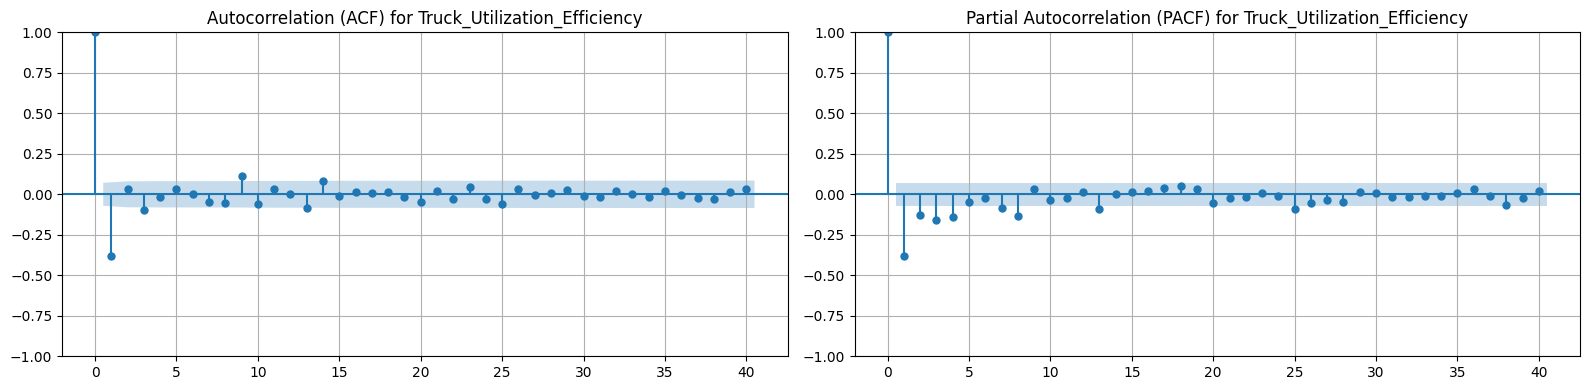

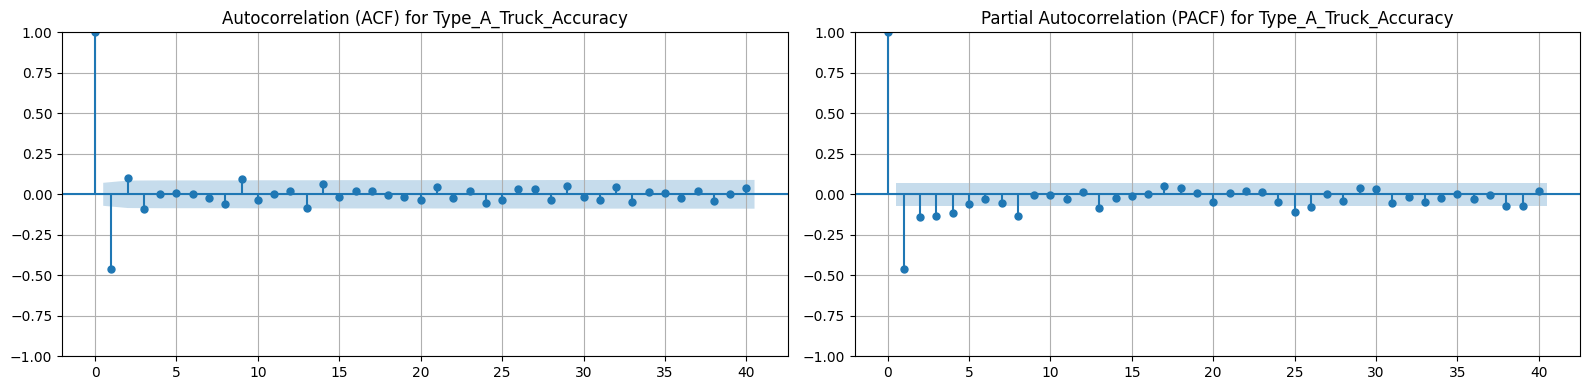

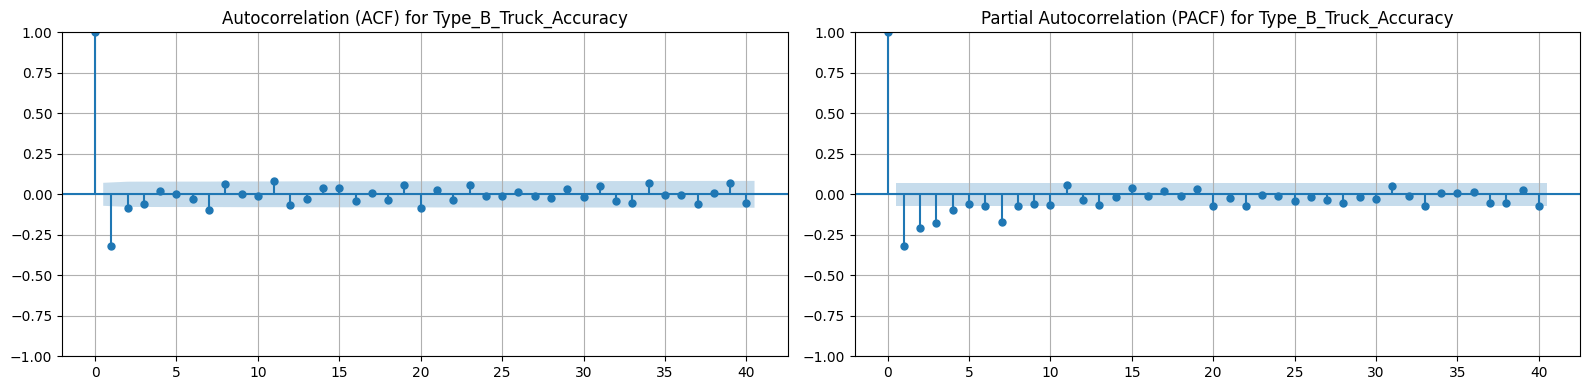

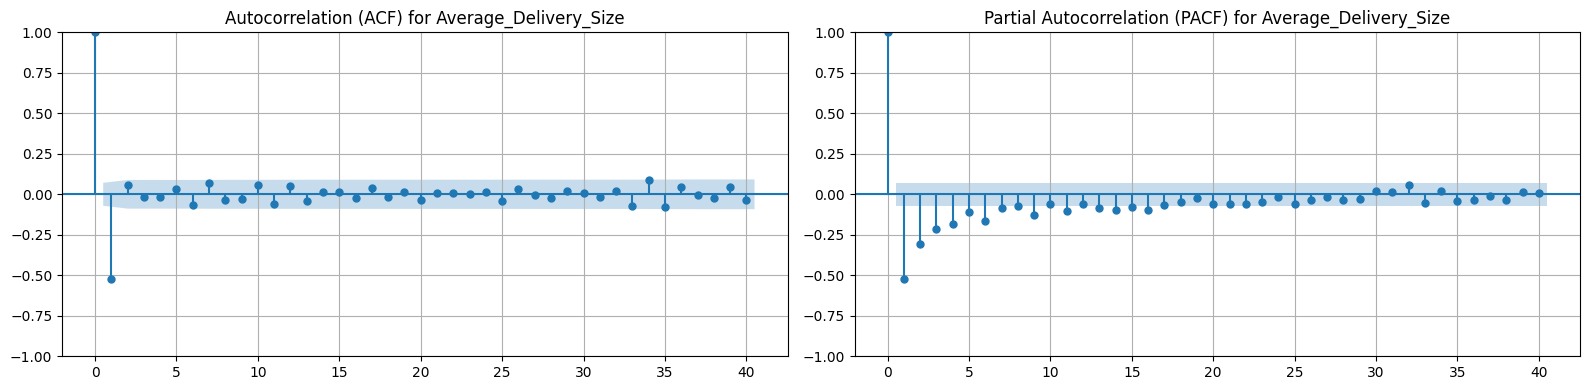

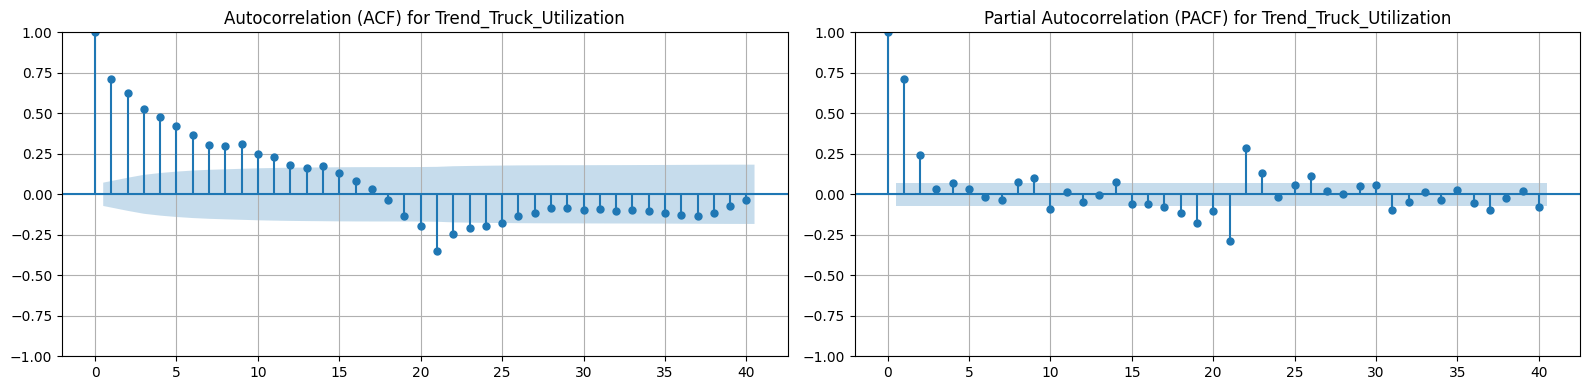

In [17]:
# Plot ACF and PACF for differenced series
for col_name in Differenced_Col:
    ut.plot_acf_pacf(df[col_name], title_suffix=f'for {col_name}')

In [18]:
# Create Lags Based on PACF and ACF results

# Reschedule_Rate -> 4 Lags
df['Reschedule_Rate_lag1'] = df['Reschedule_Rate'].shift(1)
df['Reschedule_Rate_lag2'] = df['Reschedule_Rate'].shift(2)
df['Reschedule_Rate_lag3'] = df['Reschedule_Rate'].shift(3)
df['Reschedule_Rate_lag4'] = df['Reschedule_Rate'].shift(4)


# ACTUAL_TYPE_C_TRUCKS_diff -> 5 Lags
df['ACTUAL_TYPE_C_TRUCKS_diff_lag1'] = df['ACTUAL_TYPE_C_TRUCKS_diff'].shift(1)
df['ACTUAL_TYPE_C_TRUCKS_diff_lag2'] = df['ACTUAL_TYPE_C_TRUCKS_diff'].shift(2)
df['ACTUAL_TYPE_C_TRUCKS_diff_lag3'] = df['ACTUAL_TYPE_C_TRUCKS_diff'].shift(3)
df['ACTUAL_TYPE_C_TRUCKS_diff_lag4'] = df['ACTUAL_TYPE_C_TRUCKS_diff'].shift(4)
df['ACTUAL_TYPE_C_TRUCKS_diff_lag5'] = df['ACTUAL_TYPE_C_TRUCKS_diff'].shift(5)

# ACTUAL TYPE A TRUCKS -> 4 Lags
df['ACTUAL TYPE A TRUCKS_lag1'] = df['ACTUAL TYPE A TRUCKS'].shift(1)
df['ACTUAL TYPE A TRUCKS_lag2'] = df['ACTUAL TYPE A TRUCKS'].shift(2)
df['ACTUAL TYPE A TRUCKS_lag3'] = df['ACTUAL TYPE A TRUCKS'].shift(3)
df['ACTUAL TYPE A TRUCKS_lag4'] = df['ACTUAL TYPE A TRUCKS'].shift(4)

# OUTSIDE EXTRA TYPE A TRUCKS -> 9 Lags
df['OUTSIDE EXTRA TYPE A TRUCKS_lag1'] = df['OUTSIDE EXTRA TYPE A TRUCKS'].shift(1)
df['OUTSIDE EXTRA TYPE A TRUCKS_lag2'] = df['OUTSIDE EXTRA TYPE A TRUCKS'].shift(2)
df['OUTSIDE EXTRA TYPE A TRUCKS_lag3'] = df['OUTSIDE EXTRA TYPE A TRUCKS'].shift(3)
df['OUTSIDE EXTRA TYPE A TRUCKS_lag4'] = df['OUTSIDE EXTRA TYPE A TRUCKS'].shift(4)
df['OUTSIDE EXTRA TYPE A TRUCKS_lag5'] = df['OUTSIDE EXTRA TYPE A TRUCKS'].shift(5)
df['OUTSIDE EXTRA TYPE A TRUCKS_lag6'] = df['OUTSIDE EXTRA TYPE A TRUCKS'].shift(6)
df['OUTSIDE EXTRA TYPE A TRUCKS_lag7'] = df['OUTSIDE EXTRA TYPE A TRUCKS'].shift(7)
df['OUTSIDE EXTRA TYPE A TRUCKS_lag8'] = df['OUTSIDE EXTRA TYPE A TRUCKS'].shift(8)
df['OUTSIDE EXTRA TYPE A TRUCKS_lag9'] = df['OUTSIDE EXTRA TYPE A TRUCKS'].shift(9)

# SMALL DELIVERIES (LBS) -> 9 Lags
df['SMALL DELIVERIES (LBS)_lag1'] = df['SMALL DELIVERIES (LBS)'].shift(1)
df['SMALL DELIVERIES (LBS)_lag2'] = df['SMALL DELIVERIES (LBS)'].shift(2)
df['SMALL DELIVERIES (LBS)_lag3'] = df['SMALL DELIVERIES (LBS)'].shift(3)
df['SMALL DELIVERIES (LBS)_lag4'] = df['SMALL DELIVERIES (LBS)'].shift(4)
df['SMALL DELIVERIES (LBS)_lag5'] = df['SMALL DELIVERIES (LBS)'].shift(5)
df['SMALL DELIVERIES (LBS)_lag6'] = df['SMALL DELIVERIES (LBS)'].shift(6)
df['SMALL DELIVERIES (LBS)_lag7'] = df['SMALL DELIVERIES (LBS)'].shift(7)
df['SMALL DELIVERIES (LBS)_lag8'] = df['SMALL DELIVERIES (LBS)'].shift(8)
df['SMALL DELIVERIES (LBS)_lag9'] = df['SMALL DELIVERIES (LBS)'].shift(9)

# LARGE DELIVERIES (QTY) -> 4 Lags
df['LARGE DELIVERIES (QTY)_lag1'] = df['LARGE DELIVERIES (QTY)'].shift(1)
df['LARGE DELIVERIES (QTY)_lag2'] = df['LARGE DELIVERIES (QTY)'].shift(2)
df['LARGE DELIVERIES (QTY)_lag3'] = df['LARGE DELIVERIES (QTY)'].shift(3)
df['LARGE DELIVERIES (QTY)_lag4'] = df['LARGE DELIVERIES (QTY)'].shift(4)

# SMALL DELIVERIES (QTY) -> 5 Lags
df['SMALL DELIVERIES (QTY)_lag1'] = df['SMALL DELIVERIES (QTY)'].shift(1)
df['SMALL DELIVERIES (QTY)_lag2'] = df['SMALL DELIVERIES (QTY)'].shift(2)
df['SMALL DELIVERIES (QTY)_lag3'] = df['SMALL DELIVERIES (QTY)'].shift(3)
df['SMALL DELIVERIES (QTY)_lag4'] = df['SMALL DELIVERIES (QTY)'].shift(4)
df['SMALL DELIVERIES (QTY)_lag5'] = df['SMALL DELIVERIES (QTY)'].shift(5)

# RESCHEDULES (QTY) -> 4 Lags
df['RESCHEDULES (QTY)_lag1'] = df['RESCHEDULES (QTY)'].shift(1)
df['RESCHEDULES (QTY)_lag2'] = df['RESCHEDULES (QTY)'].shift(2)
df['RESCHEDULES (QTY)_lag3'] = df['RESCHEDULES (QTY)'].shift(3)
df['RESCHEDULES (QTY)_lag4'] = df['RESCHEDULES (QTY)'].shift(4)

# RESCHEDULES (LBS) -> 6 Lags
df['RESCHEDULES (LBS)_lag1'] = df['RESCHEDULES (LBS)'].shift(1)
df['RESCHEDULES (LBS)_lag2'] = df['RESCHEDULES (LBS)'].shift(2)
df['RESCHEDULES (LBS)_lag3'] = df['RESCHEDULES (LBS)'].shift(3)
df['RESCHEDULES (LBS)_lag4'] = df['RESCHEDULES (LBS)'].shift(4)
df['RESCHEDULES (LBS)_lag5'] = df['RESCHEDULES (LBS)'].shift(5)
df['RESCHEDULES (LBS)_lag6'] = df['RESCHEDULES (LBS)'].shift(6)

# Weight_Adjusted_Reschedule_Impact -> 5 Lags
df['Weight_Adjusted_Reschedule_Impact_lag1'] = df['Weight_Adjusted_Reschedule_Impact'].shift(1)
df['Weight_Adjusted_Reschedule_Impact_lag2'] = df['Weight_Adjusted_Reschedule_Impact'].shift(2)
df['Weight_Adjusted_Reschedule_Impact_lag3'] = df['Weight_Adjusted_Reschedule_Impact'].shift(3)
df['Weight_Adjusted_Reschedule_Impact_lag4'] = df['Weight_Adjusted_Reschedule_Impact'].shift(4)
df['Weight_Adjusted_Reschedule_Impact_lag5'] = df['Weight_Adjusted_Reschedule_Impact'].shift(5)

# Type_B_Truck_Accuracy -> 4 Lags
df['Type_B_Truck_Accuracy_lag1'] = df['Type_B_Truck_Accuracy'].shift(1)
df['Type_B_Truck_Accuracy_lag2'] = df['Type_B_Truck_Accuracy'].shift(2)
df['Type_B_Truck_Accuracy_lag3'] = df['Type_B_Truck_Accuracy'].shift(3)
df['Type_B_Truck_Accuracy_lag4'] = df['Type_B_Truck_Accuracy'].shift(4)

# Average_Delivery_Size -> 6 Lags
df['Average_Delivery_Size_lag1'] = df['Average_Delivery_Size'].shift(1)
df['Average_Delivery_Size_lag2'] = df['Average_Delivery_Size'].shift(2)
df['Average_Delivery_Size_lag3'] = df['Average_Delivery_Size'].shift(3)
df['Average_Delivery_Size_lag4'] = df['Average_Delivery_Size'].shift(4)
df['Average_Delivery_Size_lag5'] = df['Average_Delivery_Size'].shift(5)
df['Average_Delivery_Size_lag6'] = df['Average_Delivery_Size'].shift(6)

# Trend_Truck_Utilization -> 2 Lags
df['Trend_Truck_Utilization_lag1'] = df['Trend_Truck_Utilization'].shift(1)
df['Trend_Truck_Utilization_lag2'] = df['Trend_Truck_Utilization'].shift(2)


In [19]:
df_model = df.copy()
df_model.dropna(inplace=True)

# Save the final DataFrame to a CSV file
df_model.to_csv('lumber_delivery_final.csv', index=True)
print("Final DataFrame saved to 'lumber_delivery_final.csv'.")

Final DataFrame saved to 'lumber_delivery_final.csv'.


Best alpha: 0.0006579332246575682
Best l1_ratio: 0.14000000000000007
R² score: 0.5368954576397588

Top 10 important features:
                                   Feature  Coefficient  Abs_Coefficient
4                    Trend_Reschedule_Rate     0.002144         0.002144
14                  SMALL DELIVERIES (QTY)    -0.001107         0.001107
24                    Reschedule_Rate_lag1     0.001046         0.001046
2                   LARGE DELIVERIES (LBS)    -0.001045         0.001045
59             SMALL DELIVERIES (QTY)_lag1    -0.000861         0.000861
19                   Average_Delivery_Size     0.000859         0.000859
5                 Seasonal_Reschedule_Rate     0.000651         0.000651
13                  LARGE DELIVERIES (QTY)    -0.000602         0.000602
78  Weight_Adjusted_Reschedule_Impact_lag5    -0.000526         0.000526
72                  RESCHEDULES (LBS)_lag5     0.000506         0.000506


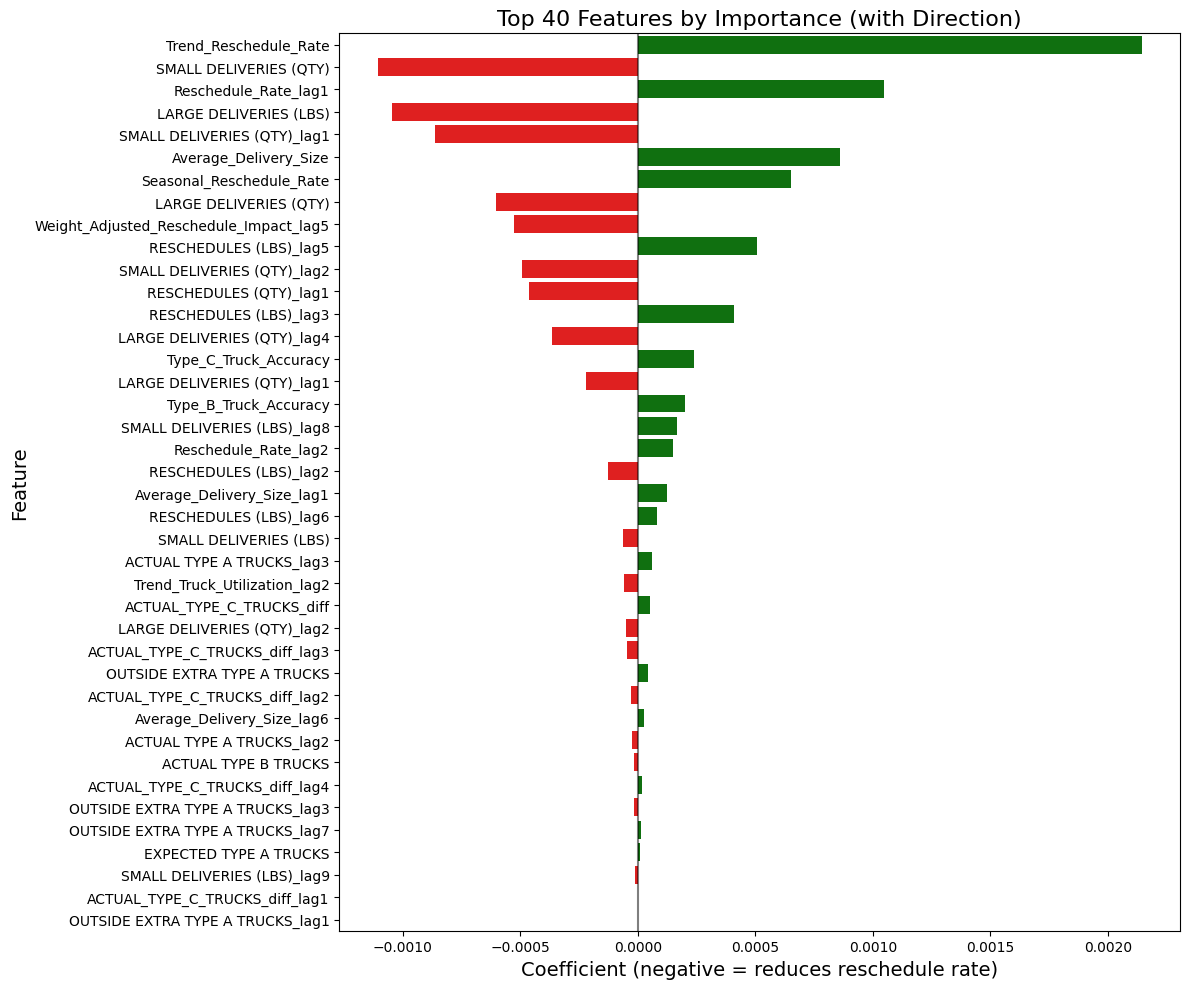

In [20]:
# Drop variables
df_model = df_model.drop(columns=['Delivery_Fulfillment_Rate', 'Weight_Adjusted_Reschedule_Impact', 'Residual_Reschedule_Rate', 'RESCHEDULES (QTY)', 'RESCHEDULES (LBS)',])

# 1. Define target and features
y = df_model['Reschedule_Rate']

X = df_model.drop(columns=['Reschedule_Rate',])

# df_model.drop(columns=['Reschedule_Rate', 'Delivery_Fulfillment_Rate', 
                           #'Weight_Adjusted_Reschedule_Impact', 
                             #'Residual_Reschedule_Rate', 'Trend_Reschedule_Rate',
                             #'RESCHEDULES (QTY)', 'RESCHEDULES (LBS)', 'GASREGW', 'EXPECTED TYPE C TRUCKS', 'Seasonal_Reschedule_Rate',])

# 2. Scale the features (important for regularization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# 3. Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# 4. Train ElasticNetCV with time series cross-validation
# l1_ratio=0.5 is a starting point (0=Ridge, 1=Lasso)
elastic_net = ElasticNetCV(
    l1_ratio=np.arange(0.05, 0.149, 0.001),
    alphas=np.logspace(-8, 1, 100),
    cv=tscv,
    max_iter=10000,
    random_state=42
)

# Fit the model
elastic_net.fit(X_scaled, y)

# 5. Extract feature importances (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': elastic_net.coef_
})

# Sort by absolute coefficient value to see most important features
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# 6. Print model information
print(f"Best alpha: {elastic_net.alpha_}")
print(f"Best l1_ratio: {elastic_net.l1_ratio_}")
print(f"R² score: {elastic_net.score(X_scaled, y)}")
print("\nTop 10 important features:")
print(feature_importance.head(10))

# 8. Create a more detailed visualization showing coefficient signs
plt.figure(figsize=(12, 10))
top_features = feature_importance.head(40)

# Use coefficient with sign for this plot
colors = ['red' if c < 0 else 'green' for c in top_features['Coefficient']]
ax = sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)
ax.set_title('Top 40 Features by Importance (with Direction)', fontsize=16)
ax.set_xlabel('Coefficient (negative = reduces reschedule rate)', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()


--- Evaluating Model Performance on Training Data ---
R² (Coefficient of Determination): 0.5369
RMSE (Root Mean Squared Error): 0.003610
MAPE (Mean Absolute Percentage Error): 3932428234090.74%


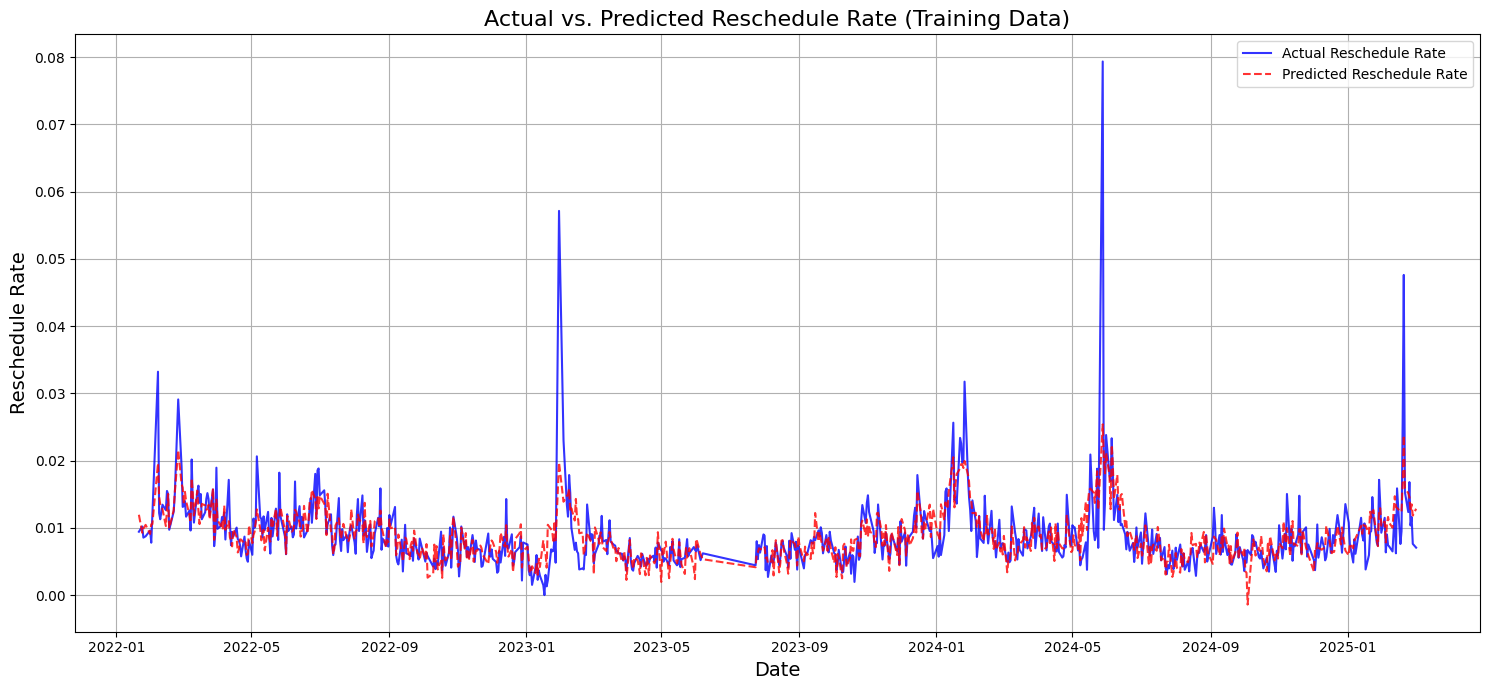

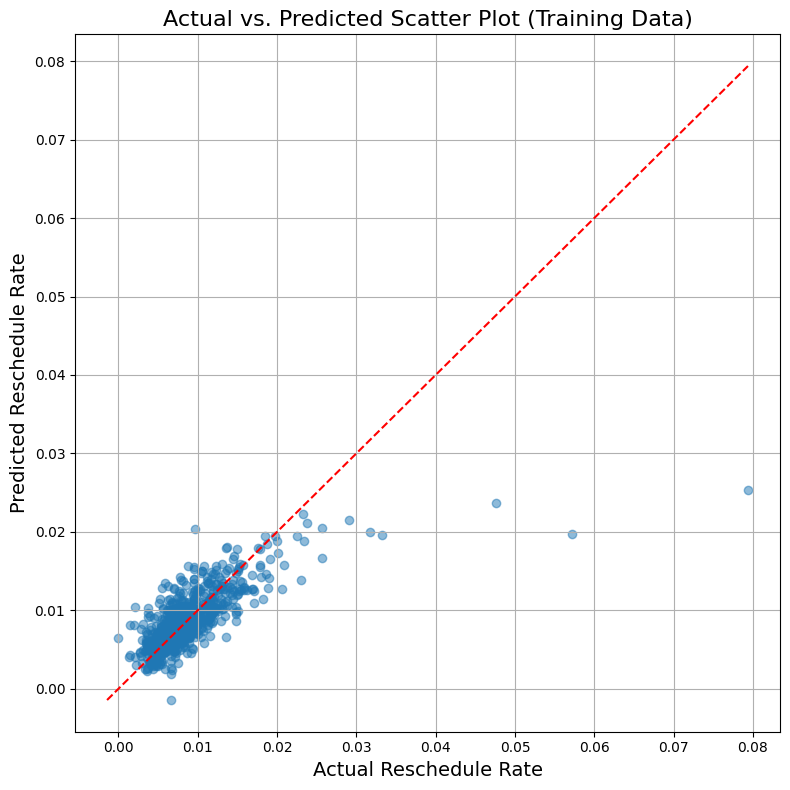

In [21]:
# --- Add this code below ---

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Ensure pandas is imported if not already

print("\n--- Evaluating Model Performance on Training Data ---")

# 1. Get Predictions
y_pred = elastic_net.predict(X_scaled)

# Ensure y_pred is a pandas Series with the same index as y for plotting
y_pred_series = pd.Series(y_pred, index=y.index, name='Predicted')

# 2. Calculate Error Metrics
r2 = r2_score(y, y_pred) # Or elastic_net.score(X_scaled, y)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
# Handle potential division by zero if actual values 'y' can be zero
# Adding a small epsilon is one way, or filtering out zeros if appropriate.
# For simplicity here, we calculate it directly. Be cautious if y has zeros.
try:
    mape = mean_absolute_percentage_error(y, y_pred) * 100 # Multiply by 100 for percentage
    print(f"R² (Coefficient of Determination): {r2:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.6f}") # Print with more precision if needed
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
except ValueError as e:
    # Handle cases where MAPE calculation might fail (e.g. division by zero)
    print(f"R² (Coefficient of Determination): {r2:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
    print(f"MAPE calculation failed: {e}")


# 3. Plot Actual vs. Predicted Values
plt.figure(figsize=(15, 7))
plt.plot(y.index, y, label='Actual Reschedule Rate', color='blue', alpha=0.8)
plt.plot(y_pred_series.index, y_pred_series, label='Predicted Reschedule Rate', color='red', linestyle='--', alpha=0.8)

plt.title('Actual vs. Predicted Reschedule Rate (Training Data)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Reschedule Rate', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Scatter Plot (Optional: Good for seeing correlation)
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.5)
# Add line y=x for reference
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.title('Actual vs. Predicted Scatter Plot (Training Data)', fontsize=16)
plt.xlabel('Actual Reschedule Rate', fontsize=14)
plt.ylabel('Predicted Reschedule Rate', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


Using DataFrame with shape: (740, 92)

Training set size: 592
Test set size: 148

NaNs in X_train_scaled: 0
NaNs in X_test_scaled: 0

Fitting ElasticNetCV model on TRAINING data...
Fitting complete.

--- Evaluating Model Performance on TEST Data ---
Test R² (Coefficient of Determination): 0.4110
Test RMSE (Root Mean Squared Error): 0.003525
Test MAPE (Mean Absolute Percentage Error): 31.19%

Parameters selected using Training Data CV:
Best alpha: 0.0028480358684358047
Best l1_ratio: 0.05900000000000001
Number of non-zero coefficients: 25


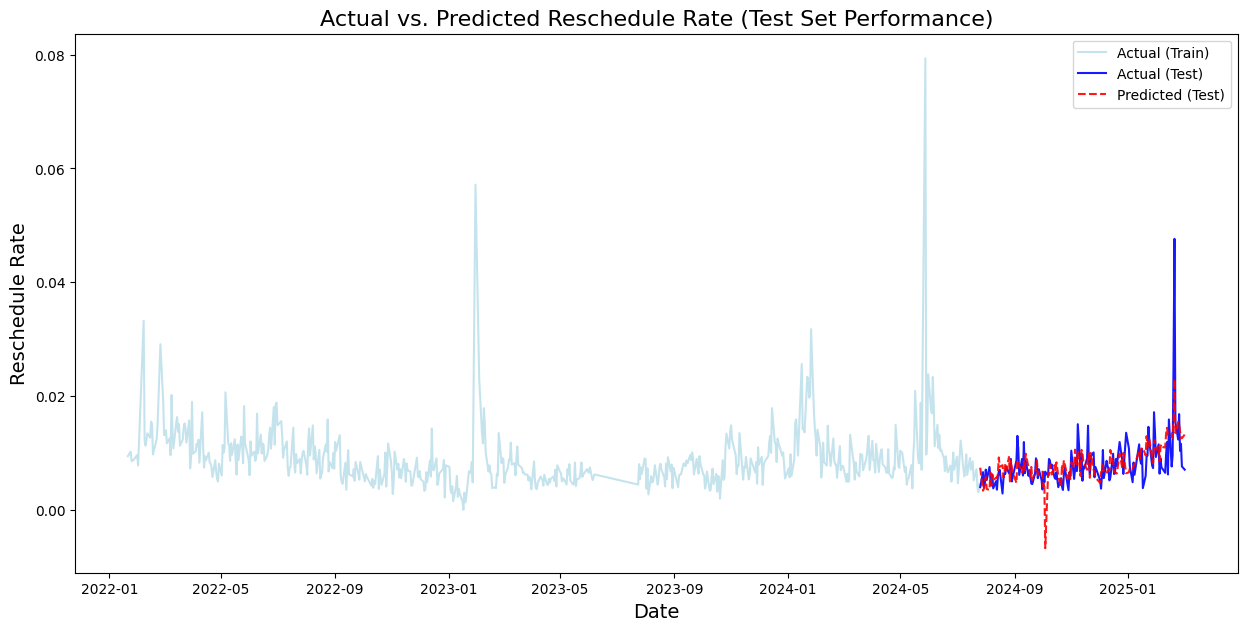

In [22]:

print(f"Using DataFrame with shape: {df_model.shape}")

# --- Out-of-Sample Validation Setup ---

# 1. Define Target and Features (from the *full* cleaned df_model)
y_full = df_model['Reschedule_Rate']
X_full = df_model.drop(columns=['Reschedule_Rate',])

# Drop constant columns if any exist in the full feature set
constant_cols_full = X_full.columns[X_full.var() == 0].tolist()
if constant_cols_full:
    print(f"Dropping constant columns from full feature set: {constant_cols_full}")
    X_full = X_full.drop(columns=constant_cols_full)

if X_full.empty:
     print("ERROR: No features left in X_full.")
else:
    # 2. Split Data into Training and Test Sets (Time Series Aware)
    test_size_ratio = 0.20 # Hold out the last 20% of data for testing
    split_index = int(len(df_model) * (1 - test_size_ratio))

    X_train = X_full.iloc[:split_index]
    X_test = X_full.iloc[split_index:]
    y_train = y_full.iloc[:split_index]
    y_test = y_full.iloc[split_index:]

    print(f"\nTraining set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    # 3. Scale Features (Fit ONLY on Training Data)
    scaler_train = StandardScaler()
    X_train_scaled = scaler_train.fit_transform(X_train)
    X_test_scaled = scaler_train.transform(X_test) # Use same scaler to transform test

    print(f"\nNaNs in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
    print(f"NaNs in X_test_scaled: {np.isnan(X_test_scaled).sum()}")


    # 4. Train ElasticNetCV (Fit ONLY on Training Data)
    # Use the same parameter grids that worked for you previously
    tscv_train = TimeSeriesSplit(n_splits=5) # CV within the training data
    elastic_net_train = ElasticNetCV(
        l1_ratio=np.arange(0.05, 0.149, 0.001), # Match successful run params
        alphas=np.logspace(-8, 1, 100),     # Match successful run params
        cv=tscv_train,
        max_iter=10000,
        random_state=42,
        n_jobs=-1
    )

    print("\nFitting ElasticNetCV model on TRAINING data...")
    elastic_net_train.fit(X_train_scaled, y_train)
    print("Fitting complete.")

    # 5. Predict on the (Unseen) Test Set
    y_pred_test = elastic_net_train.predict(X_test_scaled)
    y_pred_test_series = pd.Series(y_pred_test, index=y_test.index, name='Predicted_Test')


    # 6. Evaluate Performance on Test Set
    print("\n--- Evaluating Model Performance on TEST Data ---")
    r2_test = r2_score(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    try:
        mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
        print(f"Test R² (Coefficient of Determination): {r2_test:.4f}")
        print(f"Test RMSE (Root Mean Squared Error): {rmse_test:.6f}")
        print(f"Test MAPE (Mean Absolute Percentage Error): {mape_test:.2f}%")
    except ValueError as e:
        print(f"Test R² (Coefficient of Determination): {r2_test:.4f}")
        print(f"Test RMSE (Root Mean Squared Error): {rmse_test:.6f}")
        print(f"Test MAPE calculation failed: {e}")

    # Print parameters found using training data
    print(f"\nParameters selected using Training Data CV:")
    print(f"Best alpha: {elastic_net_train.alpha_}")
    print(f"Best l1_ratio: {elastic_net_train.l1_ratio_}")
    print(f"Number of non-zero coefficients: {np.sum(elastic_net_train.coef_ != 0)}")


    # 7. Plot Actual vs. Predicted Values for the TEST Set
    plt.figure(figsize=(15, 7))
    plt.plot(y_train.index, y_train, label='Actual (Train)', color='lightblue', alpha=0.7) # Optional: plot training data
    plt.plot(y_test.index, y_test, label='Actual (Test)', color='blue', alpha=0.9)
    plt.plot(y_pred_test_series.index, y_pred_test_series, label='Predicted (Test)', color='red', linestyle='--', alpha=0.9)

    plt.title('Actual vs. Predicted Reschedule Rate (Test Set Performance)', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Reschedule Rate', fontsize=14)
    plt.legend()


Top 25 features by importance (out-of-sample model):
                                   Feature  Coefficient  Abs_Coefficient
4                    Trend_Reschedule_Rate     0.002447         0.002447
2                   LARGE DELIVERIES (LBS)    -0.001028         0.001028
14                  SMALL DELIVERIES (QTY)    -0.000836         0.000836
19                   Average_Delivery_Size     0.000758         0.000758
24                    Reschedule_Rate_lag1     0.000692         0.000692
59             SMALL DELIVERIES (QTY)_lag1    -0.000663         0.000663
5                 Seasonal_Reschedule_Rate     0.000653         0.000653
58             LARGE DELIVERIES (QTY)_lag4    -0.000365         0.000365
64                  RESCHEDULES (QTY)_lag1    -0.000347         0.000347
3                    Type_C_Truck_Accuracy     0.000259         0.000259
13                  LARGE DELIVERIES (QTY)    -0.000256         0.000256
60             SMALL DELIVERIES (QTY)_lag2    -0.000247         0.0002

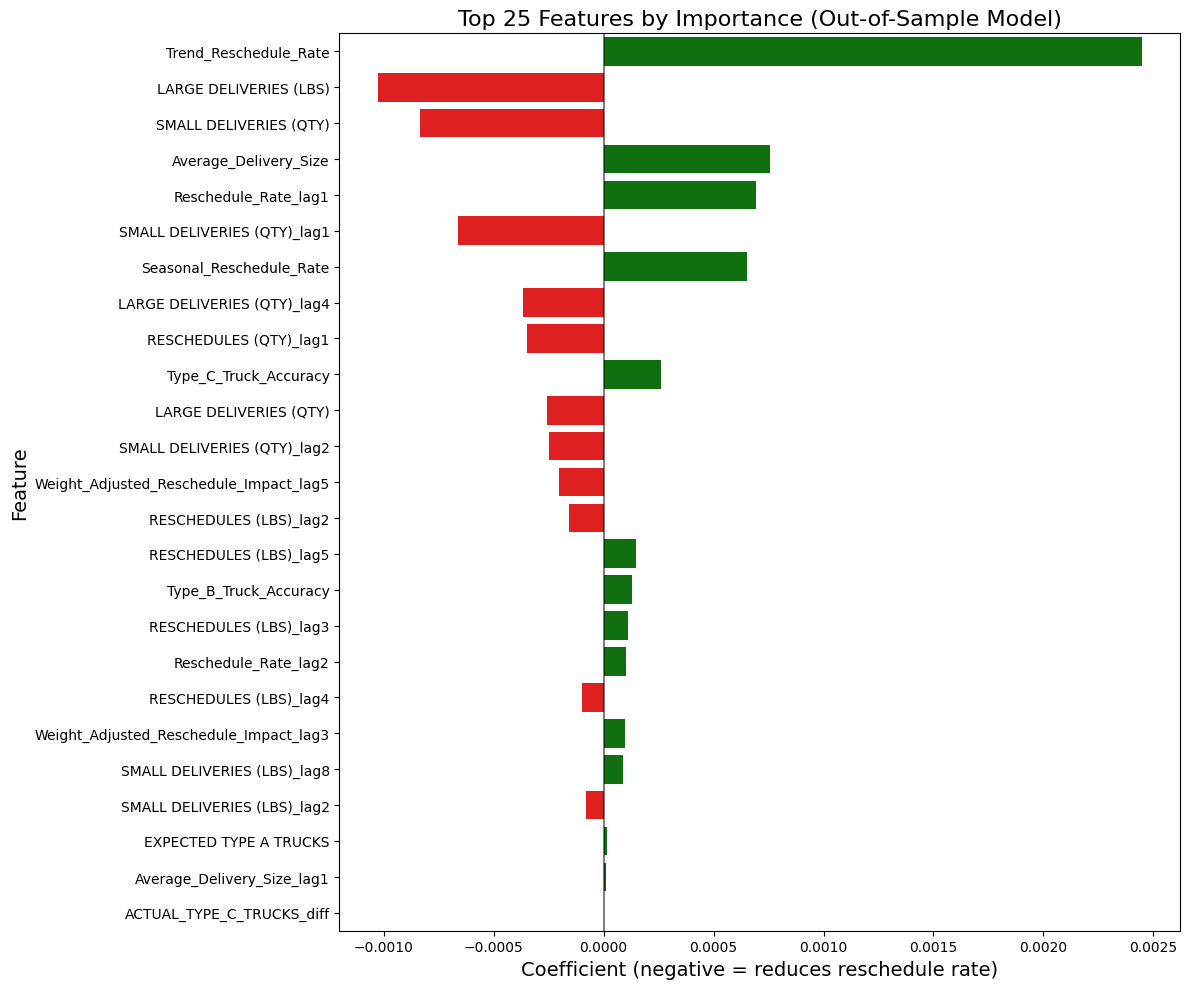

In [23]:
# Extract feature importances from the out-of-sample model
feature_importance_oos = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_net_train.coef_
})

# Sort by absolute coefficient value
feature_importance_oos['Abs_Coefficient'] = np.abs(feature_importance_oos['Coefficient'])
feature_importance_oos = feature_importance_oos.sort_values('Abs_Coefficient', ascending=False)

# Print top 25 features
print("\nTop 25 features by importance (out-of-sample model):")
print(feature_importance_oos.head(25))

# Visualize top 25 features
plt.figure(figsize=(12, 10))
top_features = feature_importance_oos.head(25)

# Create barplot with color coding (red for negative, green for positive coefficients)
colors = ['red' if c < 0 else 'green' for c in top_features['Coefficient']]
ax = sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)
ax.set_title('Top 25 Features by Importance (Out-of-Sample Model)', fontsize=16)
ax.set_xlabel('Coefficient (negative = reduces reschedule rate)', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

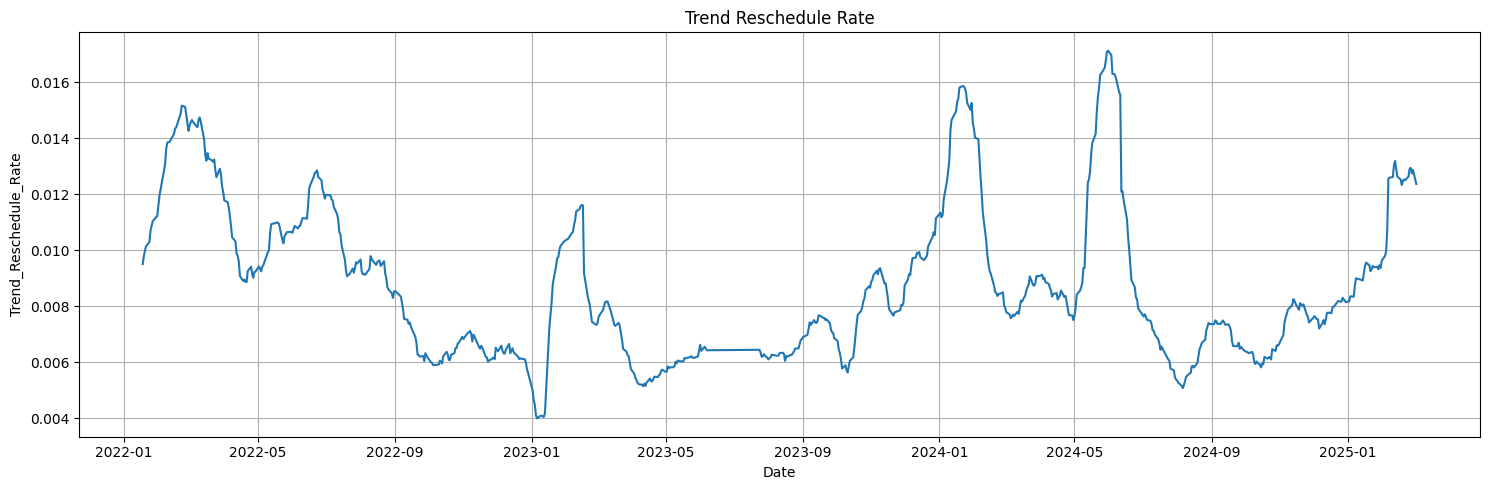

In [24]:
# Visualize Trend Reschedule Rate

ut.plot_time_series(df, 'Trend_Reschedule_Rate', title='Trend Reschedule Rate', xlabel='Date', ylabel='')

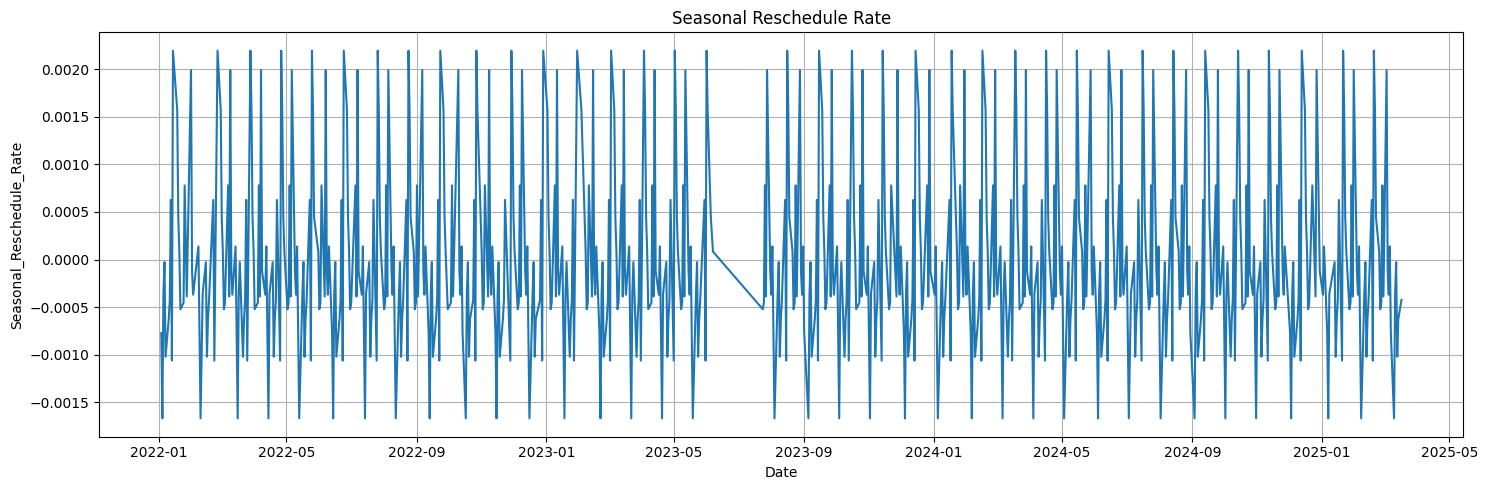

In [25]:
# Visualize Seasonal Reschedule Rate

ut.plot_time_series(df, 'Seasonal_Reschedule_Rate', title='Seasonal Reschedule Rate', xlabel='Date', ylabel='')